In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, r2_score
import optuna


SEED = 0

In [3]:
PATH = 'Предподготовленные датасеты/'

In [4]:
train = pd.read_csv(PATH + 'train_preprocessed_new_features_scaled_v2_nondownsample.csv', index_col=0)
test = pd.read_csv(PATH + 'test_preprocessed_new_features_scaled_v2_nondownsample.csv', index_col=0)

y_train = pd.read_csv(PATH + 'y_train_preprocessed_new_features.csv', index_col=0)

In [5]:
display(train.head(5))
display(test.head(5))
display(y_train.head(5))

,ticket_type_nm,entrance_id,line_id,line_length,day_week,day,hours,route_num_count,alternative_route_cnt,route_dur,optimal_route_delta_x,optimal_route_delta_y,count_entrance_id,popularity_line_id
0,-1.163408,-0.629556,-0.139116,0.215968,-0.928857,-0.929288,-0.970399,0.249966,-0.55966,-1.407915,-0.936929,-0.980049,-0.753413,1.360796
1,-1.062293,-0.629556,-0.139116,0.215968,-1.443549,-1.443861,-0.380684,0.249966,-0.55966,-1.407915,-0.936929,-0.980049,-0.753413,1.360796
2,-1.062293,-0.629556,-0.139116,0.215968,0.100527,0.099858,-0.675541,0.249966,-0.55966,-1.407915,-0.936929,-0.980049,-0.753413,1.360796
3,0.606117,-0.629556,-0.139116,0.215968,-0.928857,-0.929288,-1.265256,0.249966,-0.55966,-1.407915,-0.936929,-0.980049,-0.753413,1.360796
4,-1.062293,-0.629556,-0.139116,0.215968,-0.414165,-0.414715,-0.970399,0.249966,-0.55966,-1.407915,-0.936929,-0.980049,-0.753413,1.360796


,ticket_type_nm,entrance_id,line_id,line_length,day_week,day,hours,route_num_count,alternative_route_cnt,route_dur,optimal_route_delta_x,optimal_route_delta_y,count_entrance_id,popularity_line_id
1167408,1.263370,-0.65705,-0.218777,0.392208,0.100527,0.099858,-0.380684,-0.360328,-0.099505,0.470352,-0.053469,1.441879,-0.478249,0.603202
1167409,-0.758945,-0.65705,-0.218777,0.392208,0.615219,0.614431,-0.675541,-0.360328,-0.099505,0.470352,-0.053469,1.441879,-0.478249,0.603202
1167410,-1.163408,-0.65705,-0.218777,0.392208,1.644602,1.643577,-0.085827,-0.360328,-0.099505,0.470352,-0.053469,1.441879,-0.478249,0.603202
1167411,-1.062293,-0.65705,-0.218777,0.392208,-0.928857,-0.929288,-0.085827,-0.360328,-0.099505,0.470352,-0.053469,1.441879,-0.478249,0.603202
1167412,-1.062293,-0.65705,-0.218777,0.392208,0.100527,0.099858,1.093602,-0.360328,-0.099505,0.470352,-0.053469,1.441879,-0.478249,0.603202


,time_to_under,label
0,612.983333,2007
1,696.733333,2009
2,686.816667,8003
3,104.150000,14012
4,259.800000,1009


In [8]:
def feat_impot(model):
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(train.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.savefig('feature importance')
    plt.show()

# Сплит выборок для последовательного обучения

In [9]:
split_label = np.array_split(pd.merge(train, y_train['label'], left_index=True, right_index=True), 10)

In [11]:
split_time = np.array_split(pd.merge(train, y_train['time_to_under'], left_index=True, right_index=True), 10)

# Подбор параметров с optuna для CLF

In [23]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(train, y_train['label'], test_size=0.4)

    param = {"task_type": trial.suggest_categorical("task_type", ['CPU']),
        "depth": trial.suggest_int("depth", 1, 12, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "iterations": trial.suggest_int("depth", 500, 1000),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 14]),
        "random_state": trial.suggest_categorical("random_state", [SEED]) 
    }
    
    param['loss_function'] = 'MultiClass'
    param['use_best_model'] = True


    
    clf_opt = CatBoostClassifier(**param)

    clf_opt.fit(train_x, train_y, 
                eval_set=[(valid_x, valid_y)], 
                verbose=2, 
                early_stopping_rounds=50)

    preds = clf_opt.predict(valid_x)
    
    recall = recall_score(valid_y, preds, average='micro')
    return recall


In [24]:
study = optuna.create_study(study_name=f'catboost-seed {SEED}', direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-11-22 18:12:28,025] A new study created in memory with name: catboost-seed 0
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(


0:	learn: 5.5513745	test: 5.5517184	best: 5.5517184 (0)	total: 27.7s	remaining: 0us

bestTest = 5.551718363
bestIteration = 0



[I 2022-11-22 18:13:10,492] Trial 0 finished with value: 0.014889798785345337 and parameters: {'task_type': 'CPU', 'depth': 1, 'learning_rate': 0.18023302993445053, 'min_child_samples': 8, 'random_state': 0}. Best is trial 0 with value: 0.014889798785345337.
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(


0:	learn: 5.5507189	test: 5.5515306	best: 5.5515306 (0)	total: 33.2s	remaining: 1m 39s
2:	learn: 5.4864405	test: 5.4887654	best: 5.4887654 (2)	total: 2m 7s	remaining: 42.7s
3:	learn: 5.4698369	test: 5.4728213	best: 5.4728213 (3)	total: 2m 58s	remaining: 0us

bestTest = 5.472821264
bestIteration = 3



[I 2022-11-22 18:16:24,094] Trial 1 finished with value: 0.014947619088409385 and parameters: {'task_type': 'CPU', 'depth': 4, 'learning_rate': 0.18284377540529376, 'min_child_samples': 8, 'random_state': 0}. Best is trial 1 with value: 0.014947619088409385.
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(


0:	learn: 5.5995259	test: 5.5999961	best: 5.5999961 (0)	total: 50s	remaining: 3m 20s
2:	learn: 5.5658935	test: 5.5670619	best: 5.5670619 (2)	total: 3m 1s	remaining: 2m 1s
4:	learn: 5.5400760	test: 5.5418694	best: 5.5418694 (4)	total: 5m 47s	remaining: 0us

bestTest = 5.541869359
bestIteration = 4



[I 2022-11-22 18:22:21,713] Trial 2 finished with value: 0.01499687342064913 and parameters: {'task_type': 'CPU', 'depth': 5, 'learning_rate': 0.05086394472178941, 'min_child_samples': 1, 'random_state': 0}. Best is trial 2 with value: 0.01499687342064913.
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(


0:	learn: 5.6070485	test: 5.6075180	best: 5.6075180 (0)	total: 1m 27s	remaining: 7m 15s
2:	learn: 5.5837423	test: 5.5849975	best: 5.5849975 (2)	total: 5m 57s	remaining: 5m 57s
4:	learn: 5.5640656	test: 5.5661388	best: 5.5661388 (4)	total: 11m 52s	remaining: 2m 22s
5:	learn: 5.5553317	test: 5.5578901	best: 5.5578901 (5)	total: 15m 34s	remaining: 0us

bestTest = 5.557890149
bestIteration = 5



[I 2022-11-22 18:38:05,894] Trial 3 finished with value: 0.014641385631440539 and parameters: {'task_type': 'CPU', 'depth': 6, 'learning_rate': 0.03212359151772329, 'min_child_samples': 1, 'random_state': 0}. Best is trial 2 with value: 0.01499687342064913.
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(


0:	learn: 5.5768409	test: 5.5780340	best: 5.5780340 (0)	total: 46.8s	remaining: 3m 7s
2:	learn: 5.5217593	test: 5.5246818	best: 5.5246818 (2)	total: 3m 8s	remaining: 2m 5s
4:	learn: 5.4890967	test: 5.4934762	best: 5.4934762 (4)	total: 5m 32s	remaining: 0us

bestTest = 5.493476212
bestIteration = 4



[I 2022-11-22 18:43:49,265] Trial 4 finished with value: 0.014772016686511166 and parameters: {'task_type': 'CPU', 'depth': 5, 'learning_rate': 0.10918214921516133, 'min_child_samples': 4, 'random_state': 0}. Best is trial 2 with value: 0.01499687342064913.
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(


0:	learn: 5.5480195	test: 5.5481134	best: 5.5481134 (0)	total: 20.8s	remaining: 20.8s
1:	learn: 5.5088121	test: 5.5090413	best: 5.5090413 (1)	total: 50.5s	remaining: 0us

bestTest = 5.509041347
bestIteration = 1



[I 2022-11-22 18:44:49,351] Trial 5 finished with value: 0.014859817887460275 and parameters: {'task_type': 'CPU', 'depth': 2, 'learning_rate': 0.19113523929104853, 'min_child_samples': 1, 'random_state': 0}. Best is trial 2 with value: 0.01499687342064913.
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(


0:	learn: 5.5834473	test: 5.5836193	best: 5.5836193 (0)	total: 20.8s	remaining: 20.8s
1:	learn: 5.5556371	test: 5.5559623	best: 5.5559623 (1)	total: 51.5s	remaining: 0us

bestTest = 5.555962308
bestIteration = 1



[I 2022-11-22 18:45:52,624] Trial 6 finished with value: 0.014906930726993943 and parameters: {'task_type': 'CPU', 'depth': 2, 'learning_rate': 0.09175130987558487, 'min_child_samples': 14, 'random_state': 0}. Best is trial 2 with value: 0.01499687342064913.
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 1, 'high': 12, 'step': 1}
  warnings.warn(
[W 2022-11-22 18:47:14,222] Trial 7 failed because of the following error: CatBoostError('bad allocation')
Traceback (most recent call last):
  File "C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\study\_optimize.py", line 213, in _r

CatBoostError: bad allocation

In [25]:
clf_best_param = study.best_params

In [27]:
clf_best_param = {'task_type': 'CPU',
                  'loss_function':'MultiClass',
                     'depth': 5,
                     'learning_rate': 0.05086394472178941,
                     'min_child_samples': 1,
                     'iterations': 500,  
                     'random_state': 0,
                     'use_best_model':True,
                     'early_stopping_rounds':100}

# Обучение CatBoost CLF

In [28]:
clf = CatBoostClassifier(**clf_best_param)

In [29]:
for i,ds in enumerate(split_label):
    W=ds.values
    X=W[:,:-2].astype(float)
    Y=W[:,-1].astype(int)  
    del W
    if i==0:
        
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y,                                                          
                                                 train_size=0.80,
                                                 random_state=SEED)
        
        clf.fit(X_train, Y_train,
               eval_set=(X_val, Y_val),
                early_stopping_rounds=80
                
                
               ) 
    else:
        
        clf.fit(X, Y,
                eval_set=(X_val, Y_val),
                early_stopping_rounds=80,
                init_model='CatBoost_CLF.cbm') 
    clf.save_model('CatBoost_CLF.cbm')

0:	learn: 5.6000614	test: 5.6018829	best: 5.6018829 (0)	total: 3.96s	remaining: 32m 57s
1:	learn: 5.5822407	test: 5.5855757	best: 5.5855757 (1)	total: 7.68s	remaining: 31m 53s
2:	learn: 5.5663787	test: 5.5713902	best: 5.5713902 (2)	total: 11.5s	remaining: 31m 52s
3:	learn: 5.5521682	test: 5.5593500	best: 5.5593500 (3)	total: 15.4s	remaining: 31m 48s
4:	learn: 5.5395503	test: 5.5477612	best: 5.5477612 (4)	total: 18.9s	remaining: 31m 15s
5:	learn: 5.5279695	test: 5.5382309	best: 5.5382309 (5)	total: 22.6s	remaining: 31m 2s
6:	learn: 5.5174093	test: 5.5295916	best: 5.5295916 (6)	total: 26.5s	remaining: 31m 5s
7:	learn: 5.5079013	test: 5.5217714	best: 5.5217714 (7)	total: 30.2s	remaining: 30m 57s
8:	learn: 5.4990580	test: 5.5148754	best: 5.5148754 (8)	total: 33.9s	remaining: 30m 48s
9:	learn: 5.4910874	test: 5.5084566	best: 5.5084566 (9)	total: 37.9s	remaining: 30m 57s
10:	learn: 5.4840102	test: 5.5024139	best: 5.5024139 (10)	total: 41.9s	remaining: 31m 1s
11:	learn: 5.4776019	test: 5.4971

19:	learn: 5.4186089	test: 5.4468165	best: 5.4466698 (15)	total: 1m 30s	remaining: 36m 17s
20:	learn: 5.4165013	test: 5.4468798	best: 5.4466698 (15)	total: 1m 35s	remaining: 36m 13s
21:	learn: 5.4152324	test: 5.4469954	best: 5.4466698 (15)	total: 1m 40s	remaining: 36m 13s
22:	learn: 5.4145100	test: 5.4470638	best: 5.4466698 (15)	total: 1m 44s	remaining: 36m 9s
23:	learn: 5.4137301	test: 5.4471009	best: 5.4466698 (15)	total: 1m 49s	remaining: 36m 1s
24:	learn: 5.4120879	test: 5.4471111	best: 5.4466698 (15)	total: 1m 53s	remaining: 35m 54s
25:	learn: 5.4113444	test: 5.4471943	best: 5.4466698 (15)	total: 1m 58s	remaining: 35m 52s
26:	learn: 5.4104888	test: 5.4472160	best: 5.4466698 (15)	total: 2m 2s	remaining: 35m 45s
27:	learn: 5.4087073	test: 5.4473698	best: 5.4466698 (15)	total: 2m 7s	remaining: 35m 40s
28:	learn: 5.4074324	test: 5.4475420	best: 5.4466698 (15)	total: 2m 11s	remaining: 35m 39s
29:	learn: 5.4066768	test: 5.4476350	best: 5.4466698 (15)	total: 2m 16s	remaining: 35m 35s
30:

6:	learn: 5.4295052	test: 5.4465752	best: 5.4463658 (3)	total: 32.4s	remaining: 38m 1s
7:	learn: 5.4282208	test: 5.4467059	best: 5.4463658 (3)	total: 37.4s	remaining: 38m 21s
8:	learn: 5.4267655	test: 5.4467698	best: 5.4463658 (3)	total: 42.6s	remaining: 38m 46s
9:	learn: 5.4258080	test: 5.4468126	best: 5.4463658 (3)	total: 47.7s	remaining: 38m 59s
10:	learn: 5.4243653	test: 5.4469043	best: 5.4463658 (3)	total: 53s	remaining: 39m 16s
11:	learn: 5.4231015	test: 5.4468412	best: 5.4463658 (3)	total: 57.7s	remaining: 39m 5s
12:	learn: 5.4217568	test: 5.4468859	best: 5.4463658 (3)	total: 1m 2s	remaining: 38m 43s
13:	learn: 5.4204436	test: 5.4469673	best: 5.4463658 (3)	total: 1m 6s	remaining: 38m 25s
14:	learn: 5.4192380	test: 5.4470068	best: 5.4463658 (3)	total: 1m 10s	remaining: 38m 6s
15:	learn: 5.4184955	test: 5.4470338	best: 5.4463658 (3)	total: 1m 15s	remaining: 37m 57s
16:	learn: 5.4177785	test: 5.4470457	best: 5.4463658 (3)	total: 1m 19s	remaining: 37m 49s
17:	learn: 5.4171588	test: 

9:	learn: 5.4269705	test: 5.4467584	best: 5.4461983 (2)	total: 44.9s	remaining: 36m 39s
10:	learn: 5.4260191	test: 5.4468293	best: 5.4461983 (2)	total: 49.1s	remaining: 36m 24s
11:	learn: 5.4245312	test: 5.4469793	best: 5.4461983 (2)	total: 53.7s	remaining: 36m 25s
12:	learn: 5.4230781	test: 5.4470676	best: 5.4461983 (2)	total: 58.1s	remaining: 36m 15s
13:	learn: 5.4214288	test: 5.4472658	best: 5.4461983 (2)	total: 1m 2s	remaining: 36m 25s
14:	learn: 5.4201485	test: 5.4472981	best: 5.4461983 (2)	total: 1m 7s	remaining: 36m 29s
15:	learn: 5.4191917	test: 5.4475093	best: 5.4461983 (2)	total: 1m 12s	remaining: 36m 26s
16:	learn: 5.4184701	test: 5.4475609	best: 5.4461983 (2)	total: 1m 16s	remaining: 36m 16s
17:	learn: 5.4175049	test: 5.4477090	best: 5.4461983 (2)	total: 1m 20s	remaining: 36m 6s
18:	learn: 5.4169107	test: 5.4477146	best: 5.4461983 (2)	total: 1m 25s	remaining: 35m 53s
19:	learn: 5.4161656	test: 5.4477709	best: 5.4461983 (2)	total: 1m 29s	remaining: 35m 43s
20:	learn: 5.41561

# Подбор параметров с optuna для REG

In [30]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(train, y_train['time_to_under'], test_size=0.3)

    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 3, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['iterations'] = 2000
    param['use_best_model'] = True
    param['eval_metric'] = 'R2'
    param['random_state'] = SEED
    param['logging_level'] = 'Silent'

    
    clf_opt = CatBoostRegressor(**param)

    clf_opt.fit(train_x, train_y, 
                eval_set=[(valid_x, valid_y)], 
                verbose=2, 
                early_stopping_rounds=100)

    preds = clf_opt.predict(valid_x)
    
    r2 = r2_score(valid_y, preds)
    return r2


In [31]:
study_reg = optuna.create_study(study_name=f'catboost-reg-seed {SEED}', direction="maximize")
study_reg.optimize(objective, n_trials=50)

[I 2022-11-22 19:20:17,421] A new study created in memory with name: catboost-reg-seed 0
[I 2022-11-22 19:20:27,758] Trial 0 finished with value: 2.128110881183254e-06 and parameters: {'learning_rate': 0.010000000000000002, 'depth': 8, 'l2_leaf_reg': 4.5, 'min_child_samples': 16}. Best is trial 0 with value: 2.128110881183254e-06.
[I 2022-11-22 19:21:04,832] Trial 1 finished with value: 1.997830184619076e-07 and parameters: {'learning_rate': 0.001, 'depth': 13, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 0 with value: 2.128110881183254e-06.
[I 2022-11-22 19:21:10,266] Trial 2 finished with value: -1.8836915058884074e-06 and parameters: {'learning_rate': 0.017, 'depth': 3, 'l2_leaf_reg': 1.5, 'min_child_samples': 8}. Best is trial 0 with value: 2.128110881183254e-06.
[I 2022-11-22 19:21:29,958] Trial 3 finished with value: 1.332472343551494e-05 and parameters: {'learning_rate': 0.019000000000000003, 'depth': 10, 'l2_leaf_reg': 5.5, 'min_child_samples': 8}. Best is trial 

[I 2022-11-22 19:33:13,912] Trial 33 finished with value: -1.1502184074752009e-05 and parameters: {'learning_rate': 0.010000000000000002, 'depth': 12, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 27 with value: 1.6739408820742874e-05.
[I 2022-11-22 19:33:29,002] Trial 34 finished with value: 2.286255940753268e-05 and parameters: {'learning_rate': 0.018000000000000002, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 34 with value: 2.286255940753268e-05.
[I 2022-11-22 19:33:44,004] Trial 35 finished with value: -2.798359358013869e-06 and parameters: {'learning_rate': 0.019000000000000003, 'depth': 10, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 34 with value: 2.286255940753268e-05.
[I 2022-11-22 19:33:53,057] Trial 36 finished with value: -4.280868970418794e-07 and parameters: {'learning_rate': 0.017, 'depth': 9, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 34 with value: 2.286255940753268e-05.
[I 2022-11-22 19:34:39,60

In [32]:
reg_best_param = study_reg.best_params
reg_best_param

{'learning_rate': 0.018000000000000002,
 'depth': 9,
 'l2_leaf_reg': 1.5,
 'min_child_samples': 16}

In [47]:
reg_best_param = {'learning_rate': 0.018000000000000002,
                 'depth': 9,
                 'l2_leaf_reg': 1.5,
             'min_child_samples': 16,
                 'iterations': 2000,
                 'eval_metric': 'R2'}

# Обучение CatBoost REG

In [33]:
reg = CatBoostRegressor(**reg_best_param)

In [34]:
for i,ds in enumerate(split_time):
    W=ds.values
    X=W[:,:-2].astype(float)
    Y=W[:,-1].astype(float) 
    del W
    
    if i==0:
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y,                                                          
                                                 train_size=0.80,
                                                 random_state=SEED)
        del X,Y
        reg.fit(X_train, Y_train,
               eval_set=(X_val, Y_val), 
                early_stopping_rounds=100)
        
    else:
        reg.fit(X, Y,
                eval_set=(X_val, Y_val),
                early_stopping_rounds=100,
                init_model='CatBoost_REG.cbm')
        
    reg.save_model('CatBoost_REG.cbm')

0:	learn: 233.3940927	test: 233.6549341	best: 233.6549341 (0)	total: 8.61ms	remaining: 8.6s
1:	learn: 233.3936138	test: 233.6545344	best: 233.6545344 (1)	total: 17.1ms	remaining: 8.55s
2:	learn: 233.3855208	test: 233.6578222	best: 233.6545344 (1)	total: 29.2ms	remaining: 9.71s
3:	learn: 233.3788233	test: 233.6594826	best: 233.6545344 (1)	total: 40.3ms	remaining: 10s
4:	learn: 233.3711415	test: 233.6615209	best: 233.6545344 (1)	total: 51.6ms	remaining: 10.3s
5:	learn: 233.3675586	test: 233.6617389	best: 233.6545344 (1)	total: 62.7ms	remaining: 10.4s
6:	learn: 233.3614963	test: 233.6614314	best: 233.6545344 (1)	total: 74.9ms	remaining: 10.6s
7:	learn: 233.3557613	test: 233.6626930	best: 233.6545344 (1)	total: 86.7ms	remaining: 10.8s
8:	learn: 233.3502892	test: 233.6621676	best: 233.6545344 (1)	total: 98.2ms	remaining: 10.8s
9:	learn: 233.3462752	test: 233.6616172	best: 233.6545344 (1)	total: 109ms	remaining: 10.8s
10:	learn: 233.3387703	test: 233.6610138	best: 233.6545344 (1)	total: 120m

93:	learn: 232.9973204	test: 233.7158465	best: 233.6545344 (1)	total: 1.19s	remaining: 11.5s
94:	learn: 232.9943434	test: 233.7153828	best: 233.6545344 (1)	total: 1.21s	remaining: 11.5s
95:	learn: 232.9924286	test: 233.7153438	best: 233.6545344 (1)	total: 1.22s	remaining: 11.5s
96:	learn: 232.9902512	test: 233.7162842	best: 233.6545344 (1)	total: 1.23s	remaining: 11.5s
97:	learn: 232.9875831	test: 233.7170235	best: 233.6545344 (1)	total: 1.24s	remaining: 11.4s
98:	learn: 232.9835046	test: 233.7194749	best: 233.6545344 (1)	total: 1.25s	remaining: 11.4s
99:	learn: 232.9812737	test: 233.7206654	best: 233.6545344 (1)	total: 1.26s	remaining: 11.4s
100:	learn: 232.9767524	test: 233.7215246	best: 233.6545344 (1)	total: 1.28s	remaining: 11.4s
101:	learn: 232.9719458	test: 233.7221083	best: 233.6545344 (1)	total: 1.29s	remaining: 11.3s
102:	learn: 232.9691486	test: 233.7218135	best: 233.6545344 (1)	total: 1.3s	remaining: 11.3s
103:	learn: 232.9655995	test: 233.7212603	best: 233.6545344 (1)	tota

196:	learn: 232.7015580	test: 233.7861183	best: 233.6545344 (1)	total: 2.4s	remaining: 9.77s
197:	learn: 232.6971210	test: 233.7875707	best: 233.6545344 (1)	total: 2.41s	remaining: 9.75s
198:	learn: 232.6918478	test: 233.7876415	best: 233.6545344 (1)	total: 2.42s	remaining: 9.74s
199:	learn: 232.6885743	test: 233.7880513	best: 233.6545344 (1)	total: 2.43s	remaining: 9.73s
200:	learn: 232.6847486	test: 233.7877727	best: 233.6545344 (1)	total: 2.44s	remaining: 9.71s
201:	learn: 232.6833162	test: 233.7880878	best: 233.6545344 (1)	total: 2.46s	remaining: 9.7s
202:	learn: 232.6793493	test: 233.7887783	best: 233.6545344 (1)	total: 2.47s	remaining: 9.71s
203:	learn: 232.6772192	test: 233.7890822	best: 233.6545344 (1)	total: 2.48s	remaining: 9.69s
204:	learn: 232.6757094	test: 233.7900532	best: 233.6545344 (1)	total: 2.49s	remaining: 9.67s
205:	learn: 232.6723795	test: 233.7914523	best: 233.6545344 (1)	total: 2.5s	remaining: 9.65s
206:	learn: 232.6705911	test: 233.7910240	best: 233.6545344 (1)

296:	learn: 232.4498770	test: 233.8663459	best: 233.6545344 (1)	total: 3.57s	remaining: 8.46s
297:	learn: 232.4480255	test: 233.8663492	best: 233.6545344 (1)	total: 3.59s	remaining: 8.45s
298:	learn: 232.4475982	test: 233.8666873	best: 233.6545344 (1)	total: 3.59s	remaining: 8.43s
299:	learn: 232.4466230	test: 233.8667109	best: 233.6545344 (1)	total: 3.6s	remaining: 8.41s
300:	learn: 232.4454048	test: 233.8676814	best: 233.6545344 (1)	total: 3.62s	remaining: 8.39s
301:	learn: 232.4452825	test: 233.8677532	best: 233.6545344 (1)	total: 3.62s	remaining: 8.38s
302:	learn: 232.4443783	test: 233.8680364	best: 233.6545344 (1)	total: 3.63s	remaining: 8.36s
303:	learn: 232.4398415	test: 233.8696995	best: 233.6545344 (1)	total: 3.65s	remaining: 8.35s
304:	learn: 232.4371374	test: 233.8697234	best: 233.6545344 (1)	total: 3.66s	remaining: 8.33s
305:	learn: 232.4327304	test: 233.8690755	best: 233.6545344 (1)	total: 3.67s	remaining: 8.32s
306:	learn: 232.4310223	test: 233.8691026	best: 233.6545344 (

392:	learn: 232.2393448	test: 233.9129820	best: 233.6545344 (1)	total: 4.77s	remaining: 7.37s
393:	learn: 232.2342494	test: 233.9134779	best: 233.6545344 (1)	total: 4.78s	remaining: 7.35s
394:	learn: 232.2331227	test: 233.9145500	best: 233.6545344 (1)	total: 4.79s	remaining: 7.34s
395:	learn: 232.2286435	test: 233.9152209	best: 233.6545344 (1)	total: 4.8s	remaining: 7.33s
396:	learn: 232.2255804	test: 233.9157104	best: 233.6545344 (1)	total: 4.81s	remaining: 7.31s
397:	learn: 232.2218573	test: 233.9161712	best: 233.6545344 (1)	total: 4.83s	remaining: 7.3s
398:	learn: 232.2191474	test: 233.9168022	best: 233.6545344 (1)	total: 4.84s	remaining: 7.29s
399:	learn: 232.2168279	test: 233.9180756	best: 233.6545344 (1)	total: 4.85s	remaining: 7.27s
400:	learn: 232.2145379	test: 233.9190312	best: 233.6545344 (1)	total: 4.86s	remaining: 7.26s
401:	learn: 232.2143815	test: 233.9191214	best: 233.6545344 (1)	total: 4.87s	remaining: 7.24s
402:	learn: 232.2131033	test: 233.9198899	best: 233.6545344 (1

485:	learn: 232.0412447	test: 233.9686921	best: 233.6545344 (1)	total: 5.77s	remaining: 6.1s
486:	learn: 232.0386464	test: 233.9692753	best: 233.6545344 (1)	total: 5.78s	remaining: 6.09s
487:	learn: 232.0350395	test: 233.9681448	best: 233.6545344 (1)	total: 5.79s	remaining: 6.08s
488:	learn: 232.0317723	test: 233.9686149	best: 233.6545344 (1)	total: 5.8s	remaining: 6.07s
489:	learn: 232.0309060	test: 233.9694253	best: 233.6545344 (1)	total: 5.82s	remaining: 6.05s
490:	learn: 232.0288789	test: 233.9689335	best: 233.6545344 (1)	total: 5.83s	remaining: 6.04s
491:	learn: 232.0250916	test: 233.9701062	best: 233.6545344 (1)	total: 5.84s	remaining: 6.03s
492:	learn: 232.0250668	test: 233.9700707	best: 233.6545344 (1)	total: 5.84s	remaining: 6.01s
493:	learn: 232.0209421	test: 233.9703742	best: 233.6545344 (1)	total: 5.86s	remaining: 6s
494:	learn: 232.0176241	test: 233.9721641	best: 233.6545344 (1)	total: 5.87s	remaining: 5.98s
495:	learn: 232.0140699	test: 233.9727750	best: 233.6545344 (1)	t

577:	learn: 231.8487234	test: 234.0188076	best: 233.6545344 (1)	total: 6.76s	remaining: 4.94s
578:	learn: 231.8478036	test: 234.0193823	best: 233.6545344 (1)	total: 6.77s	remaining: 4.92s
579:	learn: 231.8467253	test: 234.0197195	best: 233.6545344 (1)	total: 6.79s	remaining: 4.91s
580:	learn: 231.8423822	test: 234.0216279	best: 233.6545344 (1)	total: 6.8s	remaining: 4.9s
581:	learn: 231.8395064	test: 234.0219897	best: 233.6545344 (1)	total: 6.81s	remaining: 4.89s
582:	learn: 231.8368516	test: 234.0239064	best: 233.6545344 (1)	total: 6.82s	remaining: 4.88s
583:	learn: 231.8320319	test: 234.0248810	best: 233.6545344 (1)	total: 6.83s	remaining: 4.87s
584:	learn: 231.8292066	test: 234.0266120	best: 233.6545344 (1)	total: 6.84s	remaining: 4.85s
585:	learn: 231.8283607	test: 234.0272767	best: 233.6545344 (1)	total: 6.85s	remaining: 4.84s
586:	learn: 231.8261971	test: 234.0283161	best: 233.6545344 (1)	total: 6.86s	remaining: 4.83s
587:	learn: 231.8234646	test: 234.0288943	best: 233.6545344 (1

667:	learn: 231.6156872	test: 234.0804016	best: 233.6545344 (1)	total: 7.76s	remaining: 3.85s
668:	learn: 231.6138286	test: 234.0806759	best: 233.6545344 (1)	total: 7.77s	remaining: 3.84s
669:	learn: 231.6113856	test: 234.0811702	best: 233.6545344 (1)	total: 7.78s	remaining: 3.83s
670:	learn: 231.6092757	test: 234.0813736	best: 233.6545344 (1)	total: 7.79s	remaining: 3.82s
671:	learn: 231.6058551	test: 234.0815019	best: 233.6545344 (1)	total: 7.8s	remaining: 3.81s
672:	learn: 231.6026604	test: 234.0804591	best: 233.6545344 (1)	total: 7.81s	remaining: 3.8s
673:	learn: 231.5992071	test: 234.0813024	best: 233.6545344 (1)	total: 7.82s	remaining: 3.78s
674:	learn: 231.5935705	test: 234.0834689	best: 233.6545344 (1)	total: 7.83s	remaining: 3.77s
675:	learn: 231.5919197	test: 234.0843299	best: 233.6545344 (1)	total: 7.85s	remaining: 3.76s
676:	learn: 231.5883189	test: 234.0844264	best: 233.6545344 (1)	total: 7.86s	remaining: 3.75s
677:	learn: 231.5846842	test: 234.0846326	best: 233.6545344 (1

755:	learn: 231.3384563	test: 234.1441967	best: 233.6545344 (1)	total: 8.74s	remaining: 2.82s
756:	learn: 231.3360072	test: 234.1447181	best: 233.6545344 (1)	total: 8.76s	remaining: 2.81s
757:	learn: 231.3332101	test: 234.1456718	best: 233.6545344 (1)	total: 8.77s	remaining: 2.8s
758:	learn: 231.3300543	test: 234.1464016	best: 233.6545344 (1)	total: 8.78s	remaining: 2.79s
759:	learn: 231.3281318	test: 234.1462177	best: 233.6545344 (1)	total: 8.79s	remaining: 2.77s
760:	learn: 231.3242674	test: 234.1490201	best: 233.6545344 (1)	total: 8.8s	remaining: 2.76s
761:	learn: 231.3209859	test: 234.1503531	best: 233.6545344 (1)	total: 8.81s	remaining: 2.75s
762:	learn: 231.3165542	test: 234.1524448	best: 233.6545344 (1)	total: 8.82s	remaining: 2.74s
763:	learn: 231.3129003	test: 234.1534467	best: 233.6545344 (1)	total: 8.83s	remaining: 2.73s
764:	learn: 231.3111695	test: 234.1536165	best: 233.6545344 (1)	total: 8.84s	remaining: 2.72s
765:	learn: 231.3061550	test: 234.1536127	best: 233.6545344 (1

845:	learn: 231.0817935	test: 234.2151823	best: 233.6545344 (1)	total: 9.74s	remaining: 1.77s
846:	learn: 231.0791078	test: 234.2156055	best: 233.6545344 (1)	total: 9.75s	remaining: 1.76s
847:	learn: 231.0778928	test: 234.2161099	best: 233.6545344 (1)	total: 9.76s	remaining: 1.75s
848:	learn: 231.0752908	test: 234.2168867	best: 233.6545344 (1)	total: 9.77s	remaining: 1.74s
849:	learn: 231.0705980	test: 234.2167334	best: 233.6545344 (1)	total: 9.79s	remaining: 1.73s
850:	learn: 231.0674145	test: 234.2177120	best: 233.6545344 (1)	total: 9.8s	remaining: 1.72s
851:	learn: 231.0655007	test: 234.2176546	best: 233.6545344 (1)	total: 9.81s	remaining: 1.7s
852:	learn: 231.0635536	test: 234.2177565	best: 233.6545344 (1)	total: 9.82s	remaining: 1.69s
853:	learn: 231.0611331	test: 234.2192890	best: 233.6545344 (1)	total: 9.83s	remaining: 1.68s
854:	learn: 231.0583500	test: 234.2197337	best: 233.6545344 (1)	total: 9.84s	remaining: 1.67s
855:	learn: 231.0559337	test: 234.2211436	best: 233.6545344 (1

934:	learn: 230.8456161	test: 234.2861830	best: 233.6545344 (1)	total: 10.9s	remaining: 760ms
935:	learn: 230.8430619	test: 234.2859730	best: 233.6545344 (1)	total: 10.9s	remaining: 748ms
936:	learn: 230.8388282	test: 234.2873575	best: 233.6545344 (1)	total: 11s	remaining: 737ms
937:	learn: 230.8361882	test: 234.2887761	best: 233.6545344 (1)	total: 11s	remaining: 725ms
938:	learn: 230.8337677	test: 234.2905367	best: 233.6545344 (1)	total: 11s	remaining: 713ms
939:	learn: 230.8308095	test: 234.2908217	best: 233.6545344 (1)	total: 11s	remaining: 701ms
940:	learn: 230.8286960	test: 234.2920883	best: 233.6545344 (1)	total: 11s	remaining: 690ms
941:	learn: 230.8260438	test: 234.2926580	best: 233.6545344 (1)	total: 11s	remaining: 678ms
942:	learn: 230.8236311	test: 234.2938035	best: 233.6545344 (1)	total: 11s	remaining: 666ms
943:	learn: 230.8195382	test: 234.2942149	best: 233.6545344 (1)	total: 11s	remaining: 655ms
944:	learn: 230.8175453	test: 234.2948144	best: 233.6545344 (1)	total: 11s	r

32:	learn: 234.1300106	test: 233.6589625	best: 233.6538666 (4)	total: 417ms	remaining: 12.2s
33:	learn: 234.1247181	test: 233.6606795	best: 233.6538666 (4)	total: 430ms	remaining: 12.2s
34:	learn: 234.1203616	test: 233.6596443	best: 233.6538666 (4)	total: 444ms	remaining: 12.2s
35:	learn: 234.1194697	test: 233.6596142	best: 233.6538666 (4)	total: 454ms	remaining: 12.2s
36:	learn: 234.1149992	test: 233.6632191	best: 233.6538666 (4)	total: 467ms	remaining: 12.2s
37:	learn: 234.1110841	test: 233.6641219	best: 233.6538666 (4)	total: 481ms	remaining: 12.2s
38:	learn: 234.1053619	test: 233.6642782	best: 233.6538666 (4)	total: 493ms	remaining: 12.2s
39:	learn: 234.1017823	test: 233.6635710	best: 233.6538666 (4)	total: 505ms	remaining: 12.1s
40:	learn: 234.0980534	test: 233.6643673	best: 233.6538666 (4)	total: 518ms	remaining: 12.1s
41:	learn: 234.0951802	test: 233.6644649	best: 233.6538666 (4)	total: 530ms	remaining: 12.1s
42:	learn: 234.0887248	test: 233.6651980	best: 233.6538666 (4)	total: 

124:	learn: 233.7799197	test: 233.6929336	best: 233.6538666 (4)	total: 1.62s	remaining: 11.4s
125:	learn: 233.7780835	test: 233.6926445	best: 233.6538666 (4)	total: 1.64s	remaining: 11.4s
126:	learn: 233.7746847	test: 233.6933161	best: 233.6538666 (4)	total: 1.65s	remaining: 11.3s
127:	learn: 233.7721791	test: 233.6938037	best: 233.6538666 (4)	total: 1.66s	remaining: 11.3s
128:	learn: 233.7700440	test: 233.6936714	best: 233.6538666 (4)	total: 1.67s	remaining: 11.3s
129:	learn: 233.7663930	test: 233.6925393	best: 233.6538666 (4)	total: 1.69s	remaining: 11.3s
130:	learn: 233.7641700	test: 233.6926746	best: 233.6538666 (4)	total: 1.7s	remaining: 11.3s
131:	learn: 233.7635913	test: 233.6927359	best: 233.6538666 (4)	total: 1.71s	remaining: 11.2s
132:	learn: 233.7592431	test: 233.6936566	best: 233.6538666 (4)	total: 1.72s	remaining: 11.2s
133:	learn: 233.7559980	test: 233.6939930	best: 233.6538666 (4)	total: 1.74s	remaining: 11.2s
134:	learn: 233.7549254	test: 233.6943688	best: 233.6538666 (

218:	learn: 233.5490830	test: 233.7176602	best: 233.6538666 (4)	total: 2.81s	remaining: 10s
219:	learn: 233.5457648	test: 233.7180196	best: 233.6538666 (4)	total: 2.82s	remaining: 10s
220:	learn: 233.5415179	test: 233.7195606	best: 233.6538666 (4)	total: 2.83s	remaining: 9.98s
221:	learn: 233.5389829	test: 233.7203180	best: 233.6538666 (4)	total: 2.85s	remaining: 9.97s
222:	learn: 233.5389825	test: 233.7203166	best: 233.6538666 (4)	total: 2.85s	remaining: 9.94s
223:	learn: 233.5351919	test: 233.7219734	best: 233.6538666 (4)	total: 2.87s	remaining: 9.93s
224:	learn: 233.5332264	test: 233.7233893	best: 233.6538666 (4)	total: 2.88s	remaining: 9.91s
225:	learn: 233.5305825	test: 233.7241927	best: 233.6538666 (4)	total: 2.89s	remaining: 9.91s
226:	learn: 233.5266503	test: 233.7252564	best: 233.6538666 (4)	total: 2.9s	remaining: 9.89s
227:	learn: 233.5250185	test: 233.7247665	best: 233.6538666 (4)	total: 2.92s	remaining: 9.89s
228:	learn: 233.5227496	test: 233.7251816	best: 233.6538666 (4)	t

314:	learn: 233.3614293	test: 233.7528100	best: 233.6538666 (4)	total: 4.02s	remaining: 8.75s
315:	learn: 233.3607315	test: 233.7529088	best: 233.6538666 (4)	total: 4.04s	remaining: 8.73s
316:	learn: 233.3598297	test: 233.7536203	best: 233.6538666 (4)	total: 4.05s	remaining: 8.72s
317:	learn: 233.3569303	test: 233.7536069	best: 233.6538666 (4)	total: 4.06s	remaining: 8.71s
318:	learn: 233.3525825	test: 233.7549157	best: 233.6538666 (4)	total: 4.08s	remaining: 8.7s
319:	learn: 233.3501414	test: 233.7562387	best: 233.6538666 (4)	total: 4.09s	remaining: 8.69s
320:	learn: 233.3499838	test: 233.7561542	best: 233.6538666 (4)	total: 4.1s	remaining: 8.67s
321:	learn: 233.3462835	test: 233.7569993	best: 233.6538666 (4)	total: 4.11s	remaining: 8.66s
322:	learn: 233.3428573	test: 233.7593593	best: 233.6538666 (4)	total: 4.13s	remaining: 8.65s
323:	learn: 233.3416795	test: 233.7601122	best: 233.6538666 (4)	total: 4.14s	remaining: 8.64s
324:	learn: 233.3416787	test: 233.7601108	best: 233.6538666 (4

410:	learn: 233.1776529	test: 233.7812664	best: 233.6538666 (4)	total: 5.24s	remaining: 7.5s
411:	learn: 233.1749623	test: 233.7822914	best: 233.6538666 (4)	total: 5.25s	remaining: 7.49s
412:	learn: 233.1724363	test: 233.7827495	best: 233.6538666 (4)	total: 5.26s	remaining: 7.48s
413:	learn: 233.1708201	test: 233.7831703	best: 233.6538666 (4)	total: 5.27s	remaining: 7.47s
414:	learn: 233.1688957	test: 233.7833247	best: 233.6538666 (4)	total: 5.29s	remaining: 7.45s
415:	learn: 233.1687988	test: 233.7832830	best: 233.6538666 (4)	total: 5.3s	remaining: 7.44s
416:	learn: 233.1683492	test: 233.7833523	best: 233.6538666 (4)	total: 5.31s	remaining: 7.42s
417:	learn: 233.1673313	test: 233.7832837	best: 233.6538666 (4)	total: 5.32s	remaining: 7.41s
418:	learn: 233.1654671	test: 233.7840499	best: 233.6538666 (4)	total: 5.33s	remaining: 7.4s
419:	learn: 233.1610935	test: 233.7842390	best: 233.6538666 (4)	total: 5.35s	remaining: 7.38s
420:	learn: 233.1602131	test: 233.7847250	best: 233.6538666 (4)

502:	learn: 232.9985472	test: 233.8072017	best: 233.6538666 (4)	total: 6.42s	remaining: 6.34s
503:	learn: 232.9980020	test: 233.8077412	best: 233.6538666 (4)	total: 6.43s	remaining: 6.33s
504:	learn: 232.9971003	test: 233.8075958	best: 233.6538666 (4)	total: 6.45s	remaining: 6.32s
505:	learn: 232.9967856	test: 233.8074986	best: 233.6538666 (4)	total: 6.46s	remaining: 6.3s
506:	learn: 232.9940969	test: 233.8079873	best: 233.6538666 (4)	total: 6.47s	remaining: 6.29s
507:	learn: 232.9925355	test: 233.8070608	best: 233.6538666 (4)	total: 6.48s	remaining: 6.28s
508:	learn: 232.9892744	test: 233.8061404	best: 233.6538666 (4)	total: 6.5s	remaining: 6.26s
509:	learn: 232.9869155	test: 233.8069969	best: 233.6538666 (4)	total: 6.51s	remaining: 6.25s
510:	learn: 232.9856289	test: 233.8058396	best: 233.6538666 (4)	total: 6.52s	remaining: 6.24s
511:	learn: 232.9834759	test: 233.8059197	best: 233.6538666 (4)	total: 6.53s	remaining: 6.23s
512:	learn: 232.9815793	test: 233.8056360	best: 233.6538666 (4

596:	learn: 232.8259401	test: 233.8317486	best: 233.6538666 (4)	total: 7.61s	remaining: 5.14s
597:	learn: 232.8227758	test: 233.8334754	best: 233.6538666 (4)	total: 7.62s	remaining: 5.12s
598:	learn: 232.8205084	test: 233.8340565	best: 233.6538666 (4)	total: 7.64s	remaining: 5.11s
599:	learn: 232.8180049	test: 233.8345773	best: 233.6538666 (4)	total: 7.65s	remaining: 5.1s
600:	learn: 232.8156381	test: 233.8338474	best: 233.6538666 (4)	total: 7.66s	remaining: 5.09s
601:	learn: 232.8155002	test: 233.8340134	best: 233.6538666 (4)	total: 7.67s	remaining: 5.07s
602:	learn: 232.8123779	test: 233.8332071	best: 233.6538666 (4)	total: 7.68s	remaining: 5.06s
603:	learn: 232.8095802	test: 233.8334218	best: 233.6538666 (4)	total: 7.7s	remaining: 5.05s
604:	learn: 232.8078772	test: 233.8345872	best: 233.6538666 (4)	total: 7.71s	remaining: 5.03s
605:	learn: 232.8050112	test: 233.8345052	best: 233.6538666 (4)	total: 7.72s	remaining: 5.02s
606:	learn: 232.8012498	test: 233.8336988	best: 233.6538666 (4

690:	learn: 232.6132831	test: 233.8626309	best: 233.6538666 (4)	total: 8.81s	remaining: 3.94s
691:	learn: 232.6123993	test: 233.8631833	best: 233.6538666 (4)	total: 8.82s	remaining: 3.93s
692:	learn: 232.6102108	test: 233.8638013	best: 233.6538666 (4)	total: 8.84s	remaining: 3.92s
693:	learn: 232.6079201	test: 233.8639087	best: 233.6538666 (4)	total: 8.85s	remaining: 3.9s
694:	learn: 232.6076187	test: 233.8643084	best: 233.6538666 (4)	total: 8.86s	remaining: 3.89s
695:	learn: 232.6049946	test: 233.8639033	best: 233.6538666 (4)	total: 8.87s	remaining: 3.88s
696:	learn: 232.6027462	test: 233.8643625	best: 233.6538666 (4)	total: 8.89s	remaining: 3.86s
697:	learn: 232.6010495	test: 233.8642473	best: 233.6538666 (4)	total: 8.9s	remaining: 3.85s
698:	learn: 232.5977986	test: 233.8652896	best: 233.6538666 (4)	total: 8.91s	remaining: 3.84s
699:	learn: 232.5952722	test: 233.8655414	best: 233.6538666 (4)	total: 8.92s	remaining: 3.82s
700:	learn: 232.5925965	test: 233.8659547	best: 233.6538666 (4

783:	learn: 232.4010640	test: 233.9031347	best: 233.6538666 (4)	total: 10s	remaining: 2.76s
784:	learn: 232.3984601	test: 233.9040633	best: 233.6538666 (4)	total: 10s	remaining: 2.74s
785:	learn: 232.3962563	test: 233.9047805	best: 233.6538666 (4)	total: 10s	remaining: 2.73s
786:	learn: 232.3945648	test: 233.9060439	best: 233.6538666 (4)	total: 10s	remaining: 2.72s
787:	learn: 232.3933027	test: 233.9076322	best: 233.6538666 (4)	total: 10.1s	remaining: 2.71s
788:	learn: 232.3920659	test: 233.9080450	best: 233.6538666 (4)	total: 10.1s	remaining: 2.69s
789:	learn: 232.3899387	test: 233.9093788	best: 233.6538666 (4)	total: 10.1s	remaining: 2.68s
790:	learn: 232.3872524	test: 233.9098768	best: 233.6538666 (4)	total: 10.1s	remaining: 2.67s
791:	learn: 232.3849226	test: 233.9108363	best: 233.6538666 (4)	total: 10.1s	remaining: 2.65s
792:	learn: 232.3820190	test: 233.9108925	best: 233.6538666 (4)	total: 10.1s	remaining: 2.64s
793:	learn: 232.3800433	test: 233.9110863	best: 233.6538666 (4)	tota

877:	learn: 232.1958697	test: 233.9448579	best: 233.6538666 (4)	total: 11.2s	remaining: 1.56s
878:	learn: 232.1945891	test: 233.9456395	best: 233.6538666 (4)	total: 11.2s	remaining: 1.54s
879:	learn: 232.1932264	test: 233.9463331	best: 233.6538666 (4)	total: 11.2s	remaining: 1.53s
880:	learn: 232.1921737	test: 233.9464105	best: 233.6538666 (4)	total: 11.2s	remaining: 1.52s
881:	learn: 232.1888531	test: 233.9455868	best: 233.6538666 (4)	total: 11.3s	remaining: 1.51s
882:	learn: 232.1870904	test: 233.9462653	best: 233.6538666 (4)	total: 11.3s	remaining: 1.49s
883:	learn: 232.1858584	test: 233.9467836	best: 233.6538666 (4)	total: 11.3s	remaining: 1.48s
884:	learn: 232.1834601	test: 233.9465656	best: 233.6538666 (4)	total: 11.3s	remaining: 1.47s
885:	learn: 232.1818387	test: 233.9476775	best: 233.6538666 (4)	total: 11.3s	remaining: 1.46s
886:	learn: 232.1802694	test: 233.9477453	best: 233.6538666 (4)	total: 11.3s	remaining: 1.44s
887:	learn: 232.1785710	test: 233.9487211	best: 233.6538666 

971:	learn: 231.9888663	test: 233.9759881	best: 233.6538666 (4)	total: 12.4s	remaining: 357ms
972:	learn: 231.9859093	test: 233.9766063	best: 233.6538666 (4)	total: 12.4s	remaining: 345ms
973:	learn: 231.9848275	test: 233.9781244	best: 233.6538666 (4)	total: 12.4s	remaining: 332ms
974:	learn: 231.9831411	test: 233.9785635	best: 233.6538666 (4)	total: 12.4s	remaining: 319ms
975:	learn: 231.9806361	test: 233.9789108	best: 233.6538666 (4)	total: 12.5s	remaining: 306ms
976:	learn: 231.9778950	test: 233.9799900	best: 233.6538666 (4)	total: 12.5s	remaining: 294ms
977:	learn: 231.9748955	test: 233.9811341	best: 233.6538666 (4)	total: 12.5s	remaining: 281ms
978:	learn: 231.9714232	test: 233.9816360	best: 233.6538666 (4)	total: 12.5s	remaining: 268ms
979:	learn: 231.9673377	test: 233.9822840	best: 233.6538666 (4)	total: 12.5s	remaining: 255ms
980:	learn: 231.9666322	test: 233.9825928	best: 233.6538666 (4)	total: 12.5s	remaining: 243ms
981:	learn: 231.9645394	test: 233.9841967	best: 233.6538666 

61:	learn: 232.6911618	test: 233.6650265	best: 233.6520834 (4)	total: 793ms	remaining: 12s
62:	learn: 232.6886545	test: 233.6645233	best: 233.6520834 (4)	total: 806ms	remaining: 12s
63:	learn: 232.6883081	test: 233.6652493	best: 233.6520834 (4)	total: 815ms	remaining: 11.9s
64:	learn: 232.6850154	test: 233.6659739	best: 233.6520834 (4)	total: 829ms	remaining: 11.9s
65:	learn: 232.6835428	test: 233.6656269	best: 233.6520834 (4)	total: 843ms	remaining: 11.9s
66:	learn: 232.6813195	test: 233.6669132	best: 233.6520834 (4)	total: 856ms	remaining: 11.9s
67:	learn: 232.6773987	test: 233.6655748	best: 233.6520834 (4)	total: 869ms	remaining: 11.9s
68:	learn: 232.6751641	test: 233.6654586	best: 233.6520834 (4)	total: 881ms	remaining: 11.9s
69:	learn: 232.6736436	test: 233.6652399	best: 233.6520834 (4)	total: 902ms	remaining: 12s
70:	learn: 232.6696740	test: 233.6671831	best: 233.6520834 (4)	total: 920ms	remaining: 12s
71:	learn: 232.6655177	test: 233.6657762	best: 233.6520834 (4)	total: 939ms	re

155:	learn: 232.4667589	test: 233.7023874	best: 233.6520834 (4)	total: 2.21s	remaining: 11.9s
156:	learn: 232.4633643	test: 233.7020487	best: 233.6520834 (4)	total: 2.23s	remaining: 12s
157:	learn: 232.4618467	test: 233.7035105	best: 233.6520834 (4)	total: 2.24s	remaining: 11.9s
158:	learn: 232.4583285	test: 233.7042232	best: 233.6520834 (4)	total: 2.26s	remaining: 11.9s
159:	learn: 232.4546075	test: 233.7038171	best: 233.6520834 (4)	total: 2.28s	remaining: 12s
160:	learn: 232.4526785	test: 233.7036661	best: 233.6520834 (4)	total: 2.29s	remaining: 12s
161:	learn: 232.4488566	test: 233.7061081	best: 233.6520834 (4)	total: 2.31s	remaining: 12s
162:	learn: 232.4472502	test: 233.7062219	best: 233.6520834 (4)	total: 2.33s	remaining: 12s
163:	learn: 232.4423873	test: 233.7067877	best: 233.6520834 (4)	total: 2.35s	remaining: 12s
164:	learn: 232.4389010	test: 233.7058995	best: 233.6520834 (4)	total: 2.37s	remaining: 12s
165:	learn: 232.4361883	test: 233.7070838	best: 233.6520834 (4)	total: 2.3

245:	learn: 232.2754604	test: 233.7359034	best: 233.6520834 (4)	total: 3.42s	remaining: 10.5s
246:	learn: 232.2744121	test: 233.7370272	best: 233.6520834 (4)	total: 3.43s	remaining: 10.5s
247:	learn: 232.2739958	test: 233.7372336	best: 233.6520834 (4)	total: 3.44s	remaining: 10.4s
248:	learn: 232.2708289	test: 233.7366454	best: 233.6520834 (4)	total: 3.46s	remaining: 10.4s
249:	learn: 232.2706262	test: 233.7365825	best: 233.6520834 (4)	total: 3.47s	remaining: 10.4s
250:	learn: 232.2672446	test: 233.7360435	best: 233.6520834 (4)	total: 3.48s	remaining: 10.4s
251:	learn: 232.2652754	test: 233.7392867	best: 233.6520834 (4)	total: 3.49s	remaining: 10.4s
252:	learn: 232.2648551	test: 233.7400255	best: 233.6520834 (4)	total: 3.51s	remaining: 10.4s
253:	learn: 232.2641964	test: 233.7403840	best: 233.6520834 (4)	total: 3.52s	remaining: 10.3s
254:	learn: 232.2637901	test: 233.7404937	best: 233.6520834 (4)	total: 3.53s	remaining: 10.3s
255:	learn: 232.2601486	test: 233.7412501	best: 233.6520834 

342:	learn: 232.1261369	test: 233.7807278	best: 233.6520834 (4)	total: 4.61s	remaining: 8.84s
343:	learn: 232.1239136	test: 233.7824382	best: 233.6520834 (4)	total: 4.63s	remaining: 8.83s
344:	learn: 232.1232492	test: 233.7825398	best: 233.6520834 (4)	total: 4.64s	remaining: 8.81s
345:	learn: 232.1226127	test: 233.7831183	best: 233.6520834 (4)	total: 4.65s	remaining: 8.8s
346:	learn: 232.1197684	test: 233.7833479	best: 233.6520834 (4)	total: 4.67s	remaining: 8.78s
347:	learn: 232.1186773	test: 233.7831200	best: 233.6520834 (4)	total: 4.68s	remaining: 8.77s
348:	learn: 232.1178171	test: 233.7833234	best: 233.6520834 (4)	total: 4.69s	remaining: 8.75s
349:	learn: 232.1174864	test: 233.7835168	best: 233.6520834 (4)	total: 4.7s	remaining: 8.73s
350:	learn: 232.1159797	test: 233.7842441	best: 233.6520834 (4)	total: 4.72s	remaining: 8.72s
351:	learn: 232.1150126	test: 233.7847548	best: 233.6520834 (4)	total: 4.73s	remaining: 8.7s
352:	learn: 232.1127812	test: 233.7845745	best: 233.6520834 (4)

439:	learn: 231.9792328	test: 233.8149115	best: 233.6520834 (4)	total: 5.81s	remaining: 7.39s
440:	learn: 231.9770146	test: 233.8137183	best: 233.6520834 (4)	total: 5.82s	remaining: 7.38s
441:	learn: 231.9769958	test: 233.8137175	best: 233.6520834 (4)	total: 5.83s	remaining: 7.36s
442:	learn: 231.9762156	test: 233.8139405	best: 233.6520834 (4)	total: 5.84s	remaining: 7.34s
443:	learn: 231.9734399	test: 233.8147362	best: 233.6520834 (4)	total: 5.86s	remaining: 7.33s
444:	learn: 231.9705757	test: 233.8141629	best: 233.6520834 (4)	total: 5.87s	remaining: 7.32s
445:	learn: 231.9698908	test: 233.8152905	best: 233.6520834 (4)	total: 5.88s	remaining: 7.3s
446:	learn: 231.9687055	test: 233.8157316	best: 233.6520834 (4)	total: 5.89s	remaining: 7.29s
447:	learn: 231.9675628	test: 233.8177657	best: 233.6520834 (4)	total: 5.91s	remaining: 7.28s
448:	learn: 231.9671563	test: 233.8175101	best: 233.6520834 (4)	total: 5.92s	remaining: 7.26s
449:	learn: 231.9648487	test: 233.8168713	best: 233.6520834 (

536:	learn: 231.8335349	test: 233.8441192	best: 233.6520834 (4)	total: 7.03s	remaining: 6.06s
537:	learn: 231.8315148	test: 233.8511234	best: 233.6520834 (4)	total: 7.04s	remaining: 6.05s
538:	learn: 231.8315038	test: 233.8511170	best: 233.6520834 (4)	total: 7.05s	remaining: 6.03s
539:	learn: 231.8297168	test: 233.8511797	best: 233.6520834 (4)	total: 7.06s	remaining: 6.02s
540:	learn: 231.8282365	test: 233.8509505	best: 233.6520834 (4)	total: 7.08s	remaining: 6s
541:	learn: 231.8258476	test: 233.8525780	best: 233.6520834 (4)	total: 7.09s	remaining: 5.99s
542:	learn: 231.8258371	test: 233.8525437	best: 233.6520834 (4)	total: 7.1s	remaining: 5.98s
543:	learn: 231.8240854	test: 233.8539635	best: 233.6520834 (4)	total: 7.11s	remaining: 5.96s
544:	learn: 231.8234654	test: 233.8541757	best: 233.6520834 (4)	total: 7.13s	remaining: 5.95s
545:	learn: 231.8224272	test: 233.8548204	best: 233.6520834 (4)	total: 7.14s	remaining: 5.93s
546:	learn: 231.8224271	test: 233.8548209	best: 233.6520834 (4)	

631:	learn: 231.6941974	test: 233.8692118	best: 233.6520834 (4)	total: 8.22s	remaining: 4.79s
632:	learn: 231.6924953	test: 233.8701903	best: 233.6520834 (4)	total: 8.24s	remaining: 4.78s
633:	learn: 231.6897926	test: 233.8707154	best: 233.6520834 (4)	total: 8.25s	remaining: 4.76s
634:	learn: 231.6862891	test: 233.8707459	best: 233.6520834 (4)	total: 8.27s	remaining: 4.75s
635:	learn: 231.6848045	test: 233.8710408	best: 233.6520834 (4)	total: 8.28s	remaining: 4.74s
636:	learn: 231.6832752	test: 233.8707657	best: 233.6520834 (4)	total: 8.29s	remaining: 4.72s
637:	learn: 231.6825635	test: 233.8711889	best: 233.6520834 (4)	total: 8.3s	remaining: 4.71s
638:	learn: 231.6804915	test: 233.8727702	best: 233.6520834 (4)	total: 8.32s	remaining: 4.7s
639:	learn: 231.6788275	test: 233.8714573	best: 233.6520834 (4)	total: 8.33s	remaining: 4.68s
640:	learn: 231.6764328	test: 233.8703370	best: 233.6520834 (4)	total: 8.34s	remaining: 4.67s
641:	learn: 231.6750406	test: 233.8712914	best: 233.6520834 (4

720:	learn: 231.4913660	test: 233.8990805	best: 233.6520834 (4)	total: 9.42s	remaining: 3.64s
721:	learn: 231.4891429	test: 233.8993624	best: 233.6520834 (4)	total: 9.43s	remaining: 3.63s
722:	learn: 231.4862752	test: 233.8995058	best: 233.6520834 (4)	total: 9.45s	remaining: 3.62s
723:	learn: 231.4845731	test: 233.8997155	best: 233.6520834 (4)	total: 9.46s	remaining: 3.6s
724:	learn: 231.4823046	test: 233.9029012	best: 233.6520834 (4)	total: 9.47s	remaining: 3.59s
725:	learn: 231.4796650	test: 233.9038589	best: 233.6520834 (4)	total: 9.48s	remaining: 3.58s
726:	learn: 231.4768206	test: 233.9041556	best: 233.6520834 (4)	total: 9.5s	remaining: 3.57s
727:	learn: 231.4748307	test: 233.9038480	best: 233.6520834 (4)	total: 9.51s	remaining: 3.55s
728:	learn: 231.4723797	test: 233.9038446	best: 233.6520834 (4)	total: 9.53s	remaining: 3.54s
729:	learn: 231.4691397	test: 233.9041454	best: 233.6520834 (4)	total: 9.54s	remaining: 3.53s
730:	learn: 231.4675185	test: 233.9058153	best: 233.6520834 (4

810:	learn: 231.2965654	test: 233.9255864	best: 233.6520834 (4)	total: 10.6s	remaining: 2.48s
811:	learn: 231.2948003	test: 233.9253003	best: 233.6520834 (4)	total: 10.6s	remaining: 2.46s
812:	learn: 231.2939518	test: 233.9254930	best: 233.6520834 (4)	total: 10.7s	remaining: 2.45s
813:	learn: 231.2921332	test: 233.9261738	best: 233.6520834 (4)	total: 10.7s	remaining: 2.44s
814:	learn: 231.2903246	test: 233.9263654	best: 233.6520834 (4)	total: 10.7s	remaining: 2.42s
815:	learn: 231.2879251	test: 233.9266981	best: 233.6520834 (4)	total: 10.7s	remaining: 2.41s
816:	learn: 231.2848596	test: 233.9266547	best: 233.6520834 (4)	total: 10.7s	remaining: 2.4s
817:	learn: 231.2838241	test: 233.9274658	best: 233.6520834 (4)	total: 10.7s	remaining: 2.38s
818:	learn: 231.2814644	test: 233.9271817	best: 233.6520834 (4)	total: 10.7s	remaining: 2.37s
819:	learn: 231.2790940	test: 233.9272585	best: 233.6520834 (4)	total: 10.7s	remaining: 2.36s
820:	learn: 231.2769939	test: 233.9287543	best: 233.6520834 (

900:	learn: 231.1063096	test: 233.9732666	best: 233.6520834 (4)	total: 11.8s	remaining: 1.3s
901:	learn: 231.1042639	test: 233.9731996	best: 233.6520834 (4)	total: 11.9s	remaining: 1.29s
902:	learn: 231.1009189	test: 233.9742913	best: 233.6520834 (4)	total: 11.9s	remaining: 1.27s
903:	learn: 231.0983916	test: 233.9765226	best: 233.6520834 (4)	total: 11.9s	remaining: 1.26s
904:	learn: 231.0967289	test: 233.9771887	best: 233.6520834 (4)	total: 11.9s	remaining: 1.25s
905:	learn: 231.0933489	test: 233.9783831	best: 233.6520834 (4)	total: 11.9s	remaining: 1.24s
906:	learn: 231.0914849	test: 233.9782814	best: 233.6520834 (4)	total: 11.9s	remaining: 1.22s
907:	learn: 231.0902253	test: 233.9793793	best: 233.6520834 (4)	total: 11.9s	remaining: 1.21s
908:	learn: 231.0892797	test: 233.9794609	best: 233.6520834 (4)	total: 12s	remaining: 1.2s
909:	learn: 231.0877465	test: 233.9789768	best: 233.6520834 (4)	total: 12s	remaining: 1.18s
910:	learn: 231.0858903	test: 233.9794934	best: 233.6520834 (4)	to

989:	learn: 230.9269131	test: 233.9980346	best: 233.6520834 (4)	total: 13s	remaining: 132ms
990:	learn: 230.9235227	test: 233.9973356	best: 233.6520834 (4)	total: 13.1s	remaining: 119ms
991:	learn: 230.9215535	test: 233.9972367	best: 233.6520834 (4)	total: 13.1s	remaining: 105ms
992:	learn: 230.9194903	test: 233.9981907	best: 233.6520834 (4)	total: 13.1s	remaining: 92.2ms
993:	learn: 230.9176285	test: 233.9982061	best: 233.6520834 (4)	total: 13.1s	remaining: 79ms
994:	learn: 230.9151093	test: 234.0000194	best: 233.6520834 (4)	total: 13.1s	remaining: 65.9ms
995:	learn: 230.9138831	test: 234.0003303	best: 233.6520834 (4)	total: 13.1s	remaining: 52.7ms
996:	learn: 230.9113904	test: 234.0010417	best: 233.6520834 (4)	total: 13.1s	remaining: 39.5ms
997:	learn: 230.9092050	test: 234.0016958	best: 233.6520834 (4)	total: 13.1s	remaining: 26.3ms
998:	learn: 230.9074172	test: 234.0025759	best: 233.6520834 (4)	total: 13.2s	remaining: 13.2ms
999:	learn: 230.9051525	test: 234.0020466	best: 233.65208

78:	learn: 233.0521207	test: 233.6544994	best: 233.6457062 (25)	total: 1.02s	remaining: 12s
79:	learn: 233.0458635	test: 233.6539711	best: 233.6457062 (25)	total: 1.04s	remaining: 12s
80:	learn: 233.0424037	test: 233.6535537	best: 233.6457062 (25)	total: 1.06s	remaining: 12s
81:	learn: 233.0388477	test: 233.6525846	best: 233.6457062 (25)	total: 1.07s	remaining: 12s
82:	learn: 233.0355946	test: 233.6527193	best: 233.6457062 (25)	total: 1.09s	remaining: 12s
83:	learn: 233.0302848	test: 233.6518764	best: 233.6457062 (25)	total: 1.1s	remaining: 12s
84:	learn: 233.0283439	test: 233.6520932	best: 233.6457062 (25)	total: 1.11s	remaining: 12s
85:	learn: 233.0239527	test: 233.6527253	best: 233.6457062 (25)	total: 1.13s	remaining: 12s
86:	learn: 233.0213856	test: 233.6531494	best: 233.6457062 (25)	total: 1.14s	remaining: 11.9s
87:	learn: 233.0185522	test: 233.6537651	best: 233.6457062 (25)	total: 1.15s	remaining: 11.9s
88:	learn: 233.0123044	test: 233.6527405	best: 233.6457062 (25)	total: 1.16s	

169:	learn: 232.7832037	test: 233.6714386	best: 233.6457062 (25)	total: 2.2s	remaining: 10.8s
170:	learn: 232.7799312	test: 233.6710819	best: 233.6457062 (25)	total: 2.21s	remaining: 10.7s
171:	learn: 232.7759803	test: 233.6714378	best: 233.6457062 (25)	total: 2.23s	remaining: 10.7s
172:	learn: 232.7734898	test: 233.6720551	best: 233.6457062 (25)	total: 2.24s	remaining: 10.7s
173:	learn: 232.7691819	test: 233.6757684	best: 233.6457062 (25)	total: 2.25s	remaining: 10.7s
174:	learn: 232.7677183	test: 233.6755096	best: 233.6457062 (25)	total: 2.27s	remaining: 10.7s
175:	learn: 232.7633177	test: 233.6751782	best: 233.6457062 (25)	total: 2.28s	remaining: 10.7s
176:	learn: 232.7601190	test: 233.6784466	best: 233.6457062 (25)	total: 2.29s	remaining: 10.7s
177:	learn: 232.7559445	test: 233.6786257	best: 233.6457062 (25)	total: 2.31s	remaining: 10.7s
178:	learn: 232.7533949	test: 233.6779936	best: 233.6457062 (25)	total: 2.32s	remaining: 10.6s
179:	learn: 232.7532086	test: 233.6775576	best: 233

259:	learn: 232.5336204	test: 233.6921555	best: 233.6457062 (25)	total: 3.39s	remaining: 9.64s
260:	learn: 232.5307657	test: 233.6916901	best: 233.6457062 (25)	total: 3.4s	remaining: 9.64s
261:	learn: 232.5277253	test: 233.6916586	best: 233.6457062 (25)	total: 3.42s	remaining: 9.64s
262:	learn: 232.5261082	test: 233.6915863	best: 233.6457062 (25)	total: 3.44s	remaining: 9.63s
263:	learn: 232.5251129	test: 233.6914185	best: 233.6457062 (25)	total: 3.45s	remaining: 9.63s
264:	learn: 232.5235545	test: 233.6917903	best: 233.6457062 (25)	total: 3.47s	remaining: 9.62s
265:	learn: 232.5195819	test: 233.6929195	best: 233.6457062 (25)	total: 3.49s	remaining: 9.62s
266:	learn: 232.5172983	test: 233.6932903	best: 233.6457062 (25)	total: 3.5s	remaining: 9.62s
267:	learn: 232.5142908	test: 233.6939173	best: 233.6457062 (25)	total: 3.52s	remaining: 9.62s
268:	learn: 232.5132229	test: 233.6942040	best: 233.6457062 (25)	total: 3.54s	remaining: 9.62s
269:	learn: 232.5119124	test: 233.6943914	best: 233.

354:	learn: 232.3356511	test: 233.7022097	best: 233.6457062 (25)	total: 4.85s	remaining: 8.81s
355:	learn: 232.3336848	test: 233.7022702	best: 233.6457062 (25)	total: 4.86s	remaining: 8.79s
356:	learn: 232.3327563	test: 233.7023408	best: 233.6457062 (25)	total: 4.87s	remaining: 8.78s
357:	learn: 232.3299301	test: 233.7025631	best: 233.6457062 (25)	total: 4.89s	remaining: 8.76s
358:	learn: 232.3286287	test: 233.7032191	best: 233.6457062 (25)	total: 4.9s	remaining: 8.75s
359:	learn: 232.3264392	test: 233.7041458	best: 233.6457062 (25)	total: 4.91s	remaining: 8.73s
360:	learn: 232.3252995	test: 233.7051856	best: 233.6457062 (25)	total: 4.92s	remaining: 8.72s
361:	learn: 232.3222925	test: 233.7056127	best: 233.6457062 (25)	total: 4.94s	remaining: 8.71s
362:	learn: 232.3222751	test: 233.7055976	best: 233.6457062 (25)	total: 4.95s	remaining: 8.69s
363:	learn: 232.3175453	test: 233.7069325	best: 233.6457062 (25)	total: 4.97s	remaining: 8.68s
364:	learn: 232.3137390	test: 233.7067491	best: 233

447:	learn: 232.1581337	test: 233.7205970	best: 233.6457062 (25)	total: 6.05s	remaining: 7.45s
448:	learn: 232.1567497	test: 233.7206755	best: 233.6457062 (25)	total: 6.06s	remaining: 7.44s
449:	learn: 232.1562518	test: 233.7210099	best: 233.6457062 (25)	total: 6.07s	remaining: 7.42s
450:	learn: 232.1550582	test: 233.7214127	best: 233.6457062 (25)	total: 6.09s	remaining: 7.41s
451:	learn: 232.1534222	test: 233.7222434	best: 233.6457062 (25)	total: 6.1s	remaining: 7.39s
452:	learn: 232.1529640	test: 233.7222918	best: 233.6457062 (25)	total: 6.11s	remaining: 7.38s
453:	learn: 232.1517197	test: 233.7226080	best: 233.6457062 (25)	total: 6.12s	remaining: 7.36s
454:	learn: 232.1504829	test: 233.7226553	best: 233.6457062 (25)	total: 6.13s	remaining: 7.35s
455:	learn: 232.1479190	test: 233.7230962	best: 233.6457062 (25)	total: 6.15s	remaining: 7.33s
456:	learn: 232.1443188	test: 233.7224862	best: 233.6457062 (25)	total: 6.16s	remaining: 7.32s
457:	learn: 232.1426728	test: 233.7223010	best: 233

541:	learn: 231.9595490	test: 233.7470725	best: 233.6457062 (25)	total: 7.25s	remaining: 6.13s
542:	learn: 231.9582257	test: 233.7471917	best: 233.6457062 (25)	total: 7.26s	remaining: 6.11s
543:	learn: 231.9577966	test: 233.7471028	best: 233.6457062 (25)	total: 7.27s	remaining: 6.1s
544:	learn: 231.9555999	test: 233.7480310	best: 233.6457062 (25)	total: 7.29s	remaining: 6.08s
545:	learn: 231.9529018	test: 233.7490902	best: 233.6457062 (25)	total: 7.3s	remaining: 6.07s
546:	learn: 231.9509350	test: 233.7501926	best: 233.6457062 (25)	total: 7.31s	remaining: 6.06s
547:	learn: 231.9498007	test: 233.7502483	best: 233.6457062 (25)	total: 7.33s	remaining: 6.04s
548:	learn: 231.9480942	test: 233.7500857	best: 233.6457062 (25)	total: 7.34s	remaining: 6.03s
549:	learn: 231.9479535	test: 233.7500149	best: 233.6457062 (25)	total: 7.35s	remaining: 6.01s
550:	learn: 231.9444569	test: 233.7509746	best: 233.6457062 (25)	total: 7.36s	remaining: 6s
551:	learn: 231.9426078	test: 233.7513093	best: 233.645

635:	learn: 231.7673083	test: 233.7657833	best: 233.6457062 (25)	total: 8.45s	remaining: 4.83s
636:	learn: 231.7647337	test: 233.7659339	best: 233.6457062 (25)	total: 8.46s	remaining: 4.82s
637:	learn: 231.7632142	test: 233.7655478	best: 233.6457062 (25)	total: 8.47s	remaining: 4.81s
638:	learn: 231.7632137	test: 233.7655491	best: 233.6457062 (25)	total: 8.48s	remaining: 4.79s
639:	learn: 231.7615420	test: 233.7657458	best: 233.6457062 (25)	total: 8.5s	remaining: 4.78s
640:	learn: 231.7568729	test: 233.7669926	best: 233.6457062 (25)	total: 8.51s	remaining: 4.77s
641:	learn: 231.7538802	test: 233.7686333	best: 233.6457062 (25)	total: 8.53s	remaining: 4.75s
642:	learn: 231.7493264	test: 233.7709263	best: 233.6457062 (25)	total: 8.54s	remaining: 4.74s
643:	learn: 231.7467332	test: 233.7712527	best: 233.6457062 (25)	total: 8.55s	remaining: 4.73s
644:	learn: 231.7451598	test: 233.7712433	best: 233.6457062 (25)	total: 8.56s	remaining: 4.71s
645:	learn: 231.7435469	test: 233.7718642	best: 233

728:	learn: 231.5579145	test: 233.7842049	best: 233.6457062 (25)	total: 9.65s	remaining: 3.59s
729:	learn: 231.5560352	test: 233.7842509	best: 233.6457062 (25)	total: 9.66s	remaining: 3.57s
730:	learn: 231.5517307	test: 233.7844719	best: 233.6457062 (25)	total: 9.68s	remaining: 3.56s
731:	learn: 231.5494213	test: 233.7844423	best: 233.6457062 (25)	total: 9.69s	remaining: 3.55s
732:	learn: 231.5467579	test: 233.7850856	best: 233.6457062 (25)	total: 9.7s	remaining: 3.53s
733:	learn: 231.5457344	test: 233.7853571	best: 233.6457062 (25)	total: 9.72s	remaining: 3.52s
734:	learn: 231.5440235	test: 233.7857930	best: 233.6457062 (25)	total: 9.73s	remaining: 3.51s
735:	learn: 231.5415515	test: 233.7853237	best: 233.6457062 (25)	total: 9.74s	remaining: 3.49s
736:	learn: 231.5387751	test: 233.7851859	best: 233.6457062 (25)	total: 9.76s	remaining: 3.48s
737:	learn: 231.5368443	test: 233.7855145	best: 233.6457062 (25)	total: 9.77s	remaining: 3.47s
738:	learn: 231.5353000	test: 233.7859262	best: 233

820:	learn: 231.3459004	test: 233.7944378	best: 233.6457062 (25)	total: 10.9s	remaining: 2.37s
821:	learn: 231.3442982	test: 233.7931577	best: 233.6457062 (25)	total: 10.9s	remaining: 2.35s
822:	learn: 231.3413203	test: 233.7928538	best: 233.6457062 (25)	total: 10.9s	remaining: 2.34s
823:	learn: 231.3380403	test: 233.7936542	best: 233.6457062 (25)	total: 10.9s	remaining: 2.33s
824:	learn: 231.3347103	test: 233.7938670	best: 233.6457062 (25)	total: 10.9s	remaining: 2.31s
825:	learn: 231.3335811	test: 233.7944070	best: 233.6457062 (25)	total: 10.9s	remaining: 2.3s
826:	learn: 231.3323639	test: 233.7940354	best: 233.6457062 (25)	total: 10.9s	remaining: 2.29s
827:	learn: 231.3301049	test: 233.7942259	best: 233.6457062 (25)	total: 10.9s	remaining: 2.27s
828:	learn: 231.3278713	test: 233.7942001	best: 233.6457062 (25)	total: 11s	remaining: 2.26s
829:	learn: 231.3252318	test: 233.7933389	best: 233.6457062 (25)	total: 11s	remaining: 2.25s
830:	learn: 231.3225312	test: 233.7929253	best: 233.645

912:	learn: 231.1229160	test: 233.8190857	best: 233.6457062 (25)	total: 12s	remaining: 1.15s
913:	learn: 231.1210466	test: 233.8191944	best: 233.6457062 (25)	total: 12.1s	remaining: 1.13s
914:	learn: 231.1196083	test: 233.8192223	best: 233.6457062 (25)	total: 12.1s	remaining: 1.12s
915:	learn: 231.1188756	test: 233.8190460	best: 233.6457062 (25)	total: 12.1s	remaining: 1.11s
916:	learn: 231.1151000	test: 233.8185713	best: 233.6457062 (25)	total: 12.1s	remaining: 1.09s
917:	learn: 231.1141626	test: 233.8182472	best: 233.6457062 (25)	total: 12.1s	remaining: 1.08s
918:	learn: 231.1133932	test: 233.8186325	best: 233.6457062 (25)	total: 12.1s	remaining: 1.07s
919:	learn: 231.1121253	test: 233.8188188	best: 233.6457062 (25)	total: 12.1s	remaining: 1.05s
920:	learn: 231.1091837	test: 233.8186969	best: 233.6457062 (25)	total: 12.1s	remaining: 1.04s
921:	learn: 231.1081078	test: 233.8185506	best: 233.6457062 (25)	total: 12.2s	remaining: 1.03s
922:	learn: 231.1047346	test: 233.8193336	best: 233.

0:	learn: 233.3641043	test: 233.6453500	best: 233.6453500 (0)	total: 13.5ms	remaining: 13.5s
1:	learn: 233.3615093	test: 233.6463380	best: 233.6453500 (0)	total: 25.1ms	remaining: 12.5s
2:	learn: 233.3560994	test: 233.6463262	best: 233.6453500 (0)	total: 38.7ms	remaining: 12.9s
3:	learn: 233.3499049	test: 233.6470108	best: 233.6453500 (0)	total: 53.2ms	remaining: 13.2s
4:	learn: 233.3458647	test: 233.6508625	best: 233.6453500 (0)	total: 66.7ms	remaining: 13.3s
5:	learn: 233.3406659	test: 233.6509348	best: 233.6453500 (0)	total: 80.2ms	remaining: 13.3s
6:	learn: 233.3346800	test: 233.6514310	best: 233.6453500 (0)	total: 94.3ms	remaining: 13.4s
7:	learn: 233.3301045	test: 233.6500866	best: 233.6453500 (0)	total: 108ms	remaining: 13.4s
8:	learn: 233.3244324	test: 233.6498599	best: 233.6453500 (0)	total: 121ms	remaining: 13.3s
9:	learn: 233.3192635	test: 233.6504743	best: 233.6453500 (0)	total: 134ms	remaining: 13.2s
10:	learn: 233.3135875	test: 233.6556138	best: 233.6453500 (0)	total: 147

90:	learn: 233.0016748	test: 233.6655675	best: 233.6453500 (0)	total: 1.22s	remaining: 12.2s
91:	learn: 232.9969886	test: 233.6659224	best: 233.6453500 (0)	total: 1.23s	remaining: 12.2s
92:	learn: 232.9924209	test: 233.6662430	best: 233.6453500 (0)	total: 1.25s	remaining: 12.2s
93:	learn: 232.9904877	test: 233.6670871	best: 233.6453500 (0)	total: 1.26s	remaining: 12.2s
94:	learn: 232.9852639	test: 233.6670053	best: 233.6453500 (0)	total: 1.27s	remaining: 12.1s
95:	learn: 232.9850222	test: 233.6667693	best: 233.6453500 (0)	total: 1.28s	remaining: 12.1s
96:	learn: 232.9828088	test: 233.6663166	best: 233.6453500 (0)	total: 1.29s	remaining: 12.1s
97:	learn: 232.9799989	test: 233.6664857	best: 233.6453500 (0)	total: 1.31s	remaining: 12s
98:	learn: 232.9783576	test: 233.6663323	best: 233.6453500 (0)	total: 1.32s	remaining: 12s
99:	learn: 232.9747656	test: 233.6672383	best: 233.6453500 (0)	total: 1.33s	remaining: 12s
100:	learn: 232.9707707	test: 233.6680501	best: 233.6453500 (0)	total: 1.35s

192:	learn: 232.7201751	test: 233.6775978	best: 233.6453500 (0)	total: 2.6s	remaining: 10.9s
193:	learn: 232.7166241	test: 233.6763170	best: 233.6453500 (0)	total: 2.61s	remaining: 10.9s
194:	learn: 232.7129709	test: 233.6767035	best: 233.6453500 (0)	total: 2.63s	remaining: 10.8s
195:	learn: 232.7126434	test: 233.6761417	best: 233.6453500 (0)	total: 2.63s	remaining: 10.8s
196:	learn: 232.7084117	test: 233.6819760	best: 233.6453500 (0)	total: 2.65s	remaining: 10.8s
197:	learn: 232.7066792	test: 233.6817048	best: 233.6453500 (0)	total: 2.66s	remaining: 10.8s
198:	learn: 232.7066051	test: 233.6817045	best: 233.6453500 (0)	total: 2.67s	remaining: 10.8s
199:	learn: 232.7040054	test: 233.6812400	best: 233.6453500 (0)	total: 2.68s	remaining: 10.7s
200:	learn: 232.7024234	test: 233.6801076	best: 233.6453500 (0)	total: 2.7s	remaining: 10.7s
201:	learn: 232.7021076	test: 233.6800685	best: 233.6453500 (0)	total: 2.71s	remaining: 10.7s
202:	learn: 232.7017866	test: 233.6811521	best: 233.6453500 (0

288:	learn: 232.5126843	test: 233.6850528	best: 233.6453500 (0)	total: 3.82s	remaining: 9.4s
289:	learn: 232.5110274	test: 233.6838466	best: 233.6453500 (0)	total: 3.83s	remaining: 9.39s
290:	learn: 232.5081012	test: 233.6839484	best: 233.6453500 (0)	total: 3.85s	remaining: 9.38s
291:	learn: 232.5035364	test: 233.6838129	best: 233.6453500 (0)	total: 3.86s	remaining: 9.37s
292:	learn: 232.5017015	test: 233.6845021	best: 233.6453500 (0)	total: 3.88s	remaining: 9.35s
293:	learn: 232.4983558	test: 233.6841158	best: 233.6453500 (0)	total: 3.89s	remaining: 9.34s
294:	learn: 232.4964436	test: 233.6845077	best: 233.6453500 (0)	total: 3.9s	remaining: 9.32s
295:	learn: 232.4941786	test: 233.6841571	best: 233.6453500 (0)	total: 3.91s	remaining: 9.31s
296:	learn: 232.4939684	test: 233.6838576	best: 233.6453500 (0)	total: 3.92s	remaining: 9.29s
297:	learn: 232.4932430	test: 233.6836479	best: 233.6453500 (0)	total: 3.93s	remaining: 9.27s
298:	learn: 232.4901337	test: 233.6825496	best: 233.6453500 (0

384:	learn: 232.3282101	test: 233.6974898	best: 233.6453500 (0)	total: 5.05s	remaining: 8.07s
385:	learn: 232.3265353	test: 233.6973689	best: 233.6453500 (0)	total: 5.07s	remaining: 8.06s
386:	learn: 232.3236492	test: 233.6975426	best: 233.6453500 (0)	total: 5.08s	remaining: 8.05s
387:	learn: 232.3215670	test: 233.6975068	best: 233.6453500 (0)	total: 5.1s	remaining: 8.04s
388:	learn: 232.3200794	test: 233.6975227	best: 233.6453500 (0)	total: 5.11s	remaining: 8.02s
389:	learn: 232.3196762	test: 233.6975631	best: 233.6453500 (0)	total: 5.12s	remaining: 8.01s
390:	learn: 232.3196597	test: 233.6975615	best: 233.6453500 (0)	total: 5.13s	remaining: 7.99s
391:	learn: 232.3180766	test: 233.6975473	best: 233.6453500 (0)	total: 5.14s	remaining: 7.97s
392:	learn: 232.3177233	test: 233.6974689	best: 233.6453500 (0)	total: 5.15s	remaining: 7.96s
393:	learn: 232.3155392	test: 233.6969216	best: 233.6453500 (0)	total: 5.17s	remaining: 7.95s
394:	learn: 232.3144214	test: 233.6970229	best: 233.6453500 (

476:	learn: 232.1574110	test: 233.6950924	best: 233.6453500 (0)	total: 6.43s	remaining: 7.05s
477:	learn: 232.1562044	test: 233.6974448	best: 233.6453500 (0)	total: 6.44s	remaining: 7.04s
478:	learn: 232.1546080	test: 233.6990291	best: 233.6453500 (0)	total: 6.46s	remaining: 7.02s
479:	learn: 232.1522917	test: 233.6984715	best: 233.6453500 (0)	total: 6.47s	remaining: 7.01s
480:	learn: 232.1487600	test: 233.6987208	best: 233.6453500 (0)	total: 6.48s	remaining: 7s
481:	learn: 232.1449956	test: 233.6994243	best: 233.6453500 (0)	total: 6.5s	remaining: 6.98s
482:	learn: 232.1440555	test: 233.6995334	best: 233.6453500 (0)	total: 6.51s	remaining: 6.97s
483:	learn: 232.1395758	test: 233.7000158	best: 233.6453500 (0)	total: 6.53s	remaining: 6.96s
484:	learn: 232.1381461	test: 233.7000317	best: 233.6453500 (0)	total: 6.54s	remaining: 6.94s
485:	learn: 232.1381461	test: 233.7000318	best: 233.6453500 (0)	total: 6.54s	remaining: 6.92s
486:	learn: 232.1366177	test: 233.7012341	best: 233.6453500 (0)	

564:	learn: 231.9923804	test: 233.7137424	best: 233.6453500 (0)	total: 7.63s	remaining: 5.88s
565:	learn: 231.9910275	test: 233.7139791	best: 233.6453500 (0)	total: 7.65s	remaining: 5.86s
566:	learn: 231.9901865	test: 233.7139456	best: 233.6453500 (0)	total: 7.66s	remaining: 5.85s
567:	learn: 231.9887422	test: 233.7135125	best: 233.6453500 (0)	total: 7.67s	remaining: 5.83s
568:	learn: 231.9852822	test: 233.7129281	best: 233.6453500 (0)	total: 7.68s	remaining: 5.82s
569:	learn: 231.9847839	test: 233.7127565	best: 233.6453500 (0)	total: 7.7s	remaining: 5.8s
570:	learn: 231.9823122	test: 233.7133876	best: 233.6453500 (0)	total: 7.71s	remaining: 5.79s
571:	learn: 231.9803083	test: 233.7123531	best: 233.6453500 (0)	total: 7.72s	remaining: 5.78s
572:	learn: 231.9803066	test: 233.7123130	best: 233.6453500 (0)	total: 7.73s	remaining: 5.76s
573:	learn: 231.9795015	test: 233.7134703	best: 233.6453500 (0)	total: 7.74s	remaining: 5.74s
574:	learn: 231.9759566	test: 233.7149325	best: 233.6453500 (0

656:	learn: 231.7895672	test: 233.7236046	best: 233.6453500 (0)	total: 8.84s	remaining: 4.61s
657:	learn: 231.7856953	test: 233.7245854	best: 233.6453500 (0)	total: 8.85s	remaining: 4.6s
658:	learn: 231.7845463	test: 233.7242244	best: 233.6453500 (0)	total: 8.87s	remaining: 4.59s
659:	learn: 231.7825887	test: 233.7243117	best: 233.6453500 (0)	total: 8.88s	remaining: 4.57s
660:	learn: 231.7819757	test: 233.7242930	best: 233.6453500 (0)	total: 8.89s	remaining: 4.56s
661:	learn: 231.7803002	test: 233.7243343	best: 233.6453500 (0)	total: 8.9s	remaining: 4.55s
662:	learn: 231.7795476	test: 233.7243343	best: 233.6453500 (0)	total: 8.92s	remaining: 4.53s
663:	learn: 231.7766231	test: 233.7253022	best: 233.6453500 (0)	total: 8.93s	remaining: 4.52s
664:	learn: 231.7737507	test: 233.7260192	best: 233.6453500 (0)	total: 8.94s	remaining: 4.5s
665:	learn: 231.7702788	test: 233.7259297	best: 233.6453500 (0)	total: 8.96s	remaining: 4.49s
666:	learn: 231.7687194	test: 233.7251773	best: 233.6453500 (0)

747:	learn: 231.5668868	test: 233.7446669	best: 233.6453500 (0)	total: 10s	remaining: 3.38s
748:	learn: 231.5645533	test: 233.7441171	best: 233.6453500 (0)	total: 10.1s	remaining: 3.37s
749:	learn: 231.5637338	test: 233.7441322	best: 233.6453500 (0)	total: 10.1s	remaining: 3.35s
750:	learn: 231.5625525	test: 233.7436442	best: 233.6453500 (0)	total: 10.1s	remaining: 3.34s
751:	learn: 231.5608437	test: 233.7437223	best: 233.6453500 (0)	total: 10.1s	remaining: 3.33s
752:	learn: 231.5578976	test: 233.7444286	best: 233.6453500 (0)	total: 10.1s	remaining: 3.31s
753:	learn: 231.5548294	test: 233.7449307	best: 233.6453500 (0)	total: 10.1s	remaining: 3.3s
754:	learn: 231.5522365	test: 233.7451249	best: 233.6453500 (0)	total: 10.1s	remaining: 3.29s
755:	learn: 231.5495163	test: 233.7453704	best: 233.6453500 (0)	total: 10.1s	remaining: 3.27s
756:	learn: 231.5475177	test: 233.7456527	best: 233.6453500 (0)	total: 10.2s	remaining: 3.26s
757:	learn: 231.5464946	test: 233.7457785	best: 233.6453500 (0)

840:	learn: 231.3515773	test: 233.7691726	best: 233.6453500 (0)	total: 11.5s	remaining: 2.17s
841:	learn: 231.3495919	test: 233.7680504	best: 233.6453500 (0)	total: 11.5s	remaining: 2.16s
842:	learn: 231.3468538	test: 233.7671121	best: 233.6453500 (0)	total: 11.5s	remaining: 2.14s
843:	learn: 231.3436823	test: 233.7671047	best: 233.6453500 (0)	total: 11.5s	remaining: 2.13s
844:	learn: 231.3417665	test: 233.7675687	best: 233.6453500 (0)	total: 11.5s	remaining: 2.11s
845:	learn: 231.3405113	test: 233.7679470	best: 233.6453500 (0)	total: 11.5s	remaining: 2.1s
846:	learn: 231.3386685	test: 233.7681059	best: 233.6453500 (0)	total: 11.6s	remaining: 2.09s
847:	learn: 231.3353391	test: 233.7691327	best: 233.6453500 (0)	total: 11.6s	remaining: 2.07s
848:	learn: 231.3343090	test: 233.7692376	best: 233.6453500 (0)	total: 11.6s	remaining: 2.06s
849:	learn: 231.3327919	test: 233.7702122	best: 233.6453500 (0)	total: 11.6s	remaining: 2.04s
850:	learn: 231.3297378	test: 233.7711185	best: 233.6453500 (

930:	learn: 231.1381734	test: 233.7950359	best: 233.6453500 (0)	total: 12.7s	remaining: 939ms
931:	learn: 231.1353454	test: 233.7942998	best: 233.6453500 (0)	total: 12.7s	remaining: 926ms
932:	learn: 231.1335270	test: 233.7937886	best: 233.6453500 (0)	total: 12.7s	remaining: 912ms
933:	learn: 231.1304602	test: 233.7934122	best: 233.6453500 (0)	total: 12.7s	remaining: 899ms
934:	learn: 231.1287636	test: 233.7934749	best: 233.6453500 (0)	total: 12.7s	remaining: 885ms
935:	learn: 231.1277182	test: 233.7934962	best: 233.6453500 (0)	total: 12.7s	remaining: 871ms
936:	learn: 231.1224236	test: 233.7951989	best: 233.6453500 (0)	total: 12.8s	remaining: 858ms
937:	learn: 231.1187049	test: 233.7952950	best: 233.6453500 (0)	total: 12.8s	remaining: 844ms
938:	learn: 231.1175030	test: 233.7949750	best: 233.6453500 (0)	total: 12.8s	remaining: 830ms
939:	learn: 231.1151804	test: 233.7945455	best: 233.6453500 (0)	total: 12.8s	remaining: 817ms
940:	learn: 231.1130430	test: 233.7947383	best: 233.6453500 

31:	learn: 233.7898992	test: 233.6516479	best: 233.6441260 (2)	total: 405ms	remaining: 12.2s
32:	learn: 233.7873626	test: 233.6511229	best: 233.6441260 (2)	total: 418ms	remaining: 12.2s
33:	learn: 233.7828142	test: 233.6508219	best: 233.6441260 (2)	total: 431ms	remaining: 12.2s
34:	learn: 233.7810288	test: 233.6503903	best: 233.6441260 (2)	total: 444ms	remaining: 12.3s
35:	learn: 233.7739197	test: 233.6504831	best: 233.6441260 (2)	total: 458ms	remaining: 12.3s
36:	learn: 233.7717864	test: 233.6505144	best: 233.6441260 (2)	total: 470ms	remaining: 12.2s
37:	learn: 233.7664634	test: 233.6511276	best: 233.6441260 (2)	total: 485ms	remaining: 12.3s
38:	learn: 233.7627990	test: 233.6518173	best: 233.6441260 (2)	total: 497ms	remaining: 12.3s
39:	learn: 233.7569105	test: 233.6515814	best: 233.6441260 (2)	total: 510ms	remaining: 12.3s
40:	learn: 233.7529288	test: 233.6515418	best: 233.6441260 (2)	total: 523ms	remaining: 12.2s
41:	learn: 233.7527889	test: 233.6516952	best: 233.6441260 (2)	total: 

120:	learn: 233.4753975	test: 233.6754916	best: 233.6441260 (2)	total: 1.82s	remaining: 13.2s
121:	learn: 233.4729926	test: 233.6757972	best: 233.6441260 (2)	total: 1.83s	remaining: 13.2s
122:	learn: 233.4694346	test: 233.6757753	best: 233.6441260 (2)	total: 1.85s	remaining: 13.2s
123:	learn: 233.4669565	test: 233.6746318	best: 233.6441260 (2)	total: 1.86s	remaining: 13.2s
124:	learn: 233.4632208	test: 233.6754583	best: 233.6441260 (2)	total: 1.88s	remaining: 13.1s
125:	learn: 233.4567817	test: 233.6763454	best: 233.6441260 (2)	total: 1.89s	remaining: 13.1s
126:	learn: 233.4545031	test: 233.6766182	best: 233.6441260 (2)	total: 1.91s	remaining: 13.1s
127:	learn: 233.4477244	test: 233.6767223	best: 233.6441260 (2)	total: 1.92s	remaining: 13.1s
128:	learn: 233.4437016	test: 233.6785023	best: 233.6441260 (2)	total: 1.94s	remaining: 13.1s
129:	learn: 233.4435871	test: 233.6786341	best: 233.6441260 (2)	total: 1.95s	remaining: 13s
130:	learn: 233.4410111	test: 233.6788795	best: 233.6441260 (2

208:	learn: 233.2029183	test: 233.7087136	best: 233.6441260 (2)	total: 3.01s	remaining: 11.4s
209:	learn: 233.1972310	test: 233.7095787	best: 233.6441260 (2)	total: 3.02s	remaining: 11.4s
210:	learn: 233.1921486	test: 233.7100013	best: 233.6441260 (2)	total: 3.04s	remaining: 11.4s
211:	learn: 233.1921133	test: 233.7100281	best: 233.6441260 (2)	total: 3.05s	remaining: 11.3s
212:	learn: 233.1908561	test: 233.7084853	best: 233.6441260 (2)	total: 3.06s	remaining: 11.3s
213:	learn: 233.1880528	test: 233.7087756	best: 233.6441260 (2)	total: 3.07s	remaining: 11.3s
214:	learn: 233.1852648	test: 233.7085448	best: 233.6441260 (2)	total: 3.09s	remaining: 11.3s
215:	learn: 233.1818149	test: 233.7089437	best: 233.6441260 (2)	total: 3.1s	remaining: 11.3s
216:	learn: 233.1800774	test: 233.7092422	best: 233.6441260 (2)	total: 3.11s	remaining: 11.2s
217:	learn: 233.1778518	test: 233.7094437	best: 233.6441260 (2)	total: 3.13s	remaining: 11.2s
218:	learn: 233.1777797	test: 233.7094487	best: 233.6441260 (

297:	learn: 232.9729144	test: 233.7238888	best: 233.6441260 (2)	total: 4.2s	remaining: 9.9s
298:	learn: 232.9719789	test: 233.7239953	best: 233.6441260 (2)	total: 4.21s	remaining: 9.88s
299:	learn: 232.9697537	test: 233.7245891	best: 233.6441260 (2)	total: 4.23s	remaining: 9.86s
300:	learn: 232.9678846	test: 233.7250791	best: 233.6441260 (2)	total: 4.24s	remaining: 9.85s
301:	learn: 232.9649894	test: 233.7256806	best: 233.6441260 (2)	total: 4.25s	remaining: 9.84s
302:	learn: 232.9626906	test: 233.7259483	best: 233.6441260 (2)	total: 4.27s	remaining: 9.82s
303:	learn: 232.9597165	test: 233.7260403	best: 233.6441260 (2)	total: 4.28s	remaining: 9.8s
304:	learn: 232.9573316	test: 233.7273305	best: 233.6441260 (2)	total: 4.3s	remaining: 9.8s
305:	learn: 232.9533220	test: 233.7270382	best: 233.6441260 (2)	total: 4.32s	remaining: 9.79s
306:	learn: 232.9506704	test: 233.7264939	best: 233.6441260 (2)	total: 4.33s	remaining: 9.78s
307:	learn: 232.9479800	test: 233.7266778	best: 233.6441260 (2)	t

386:	learn: 232.7709709	test: 233.7404815	best: 233.6441260 (2)	total: 5.41s	remaining: 8.56s
387:	learn: 232.7685981	test: 233.7419117	best: 233.6441260 (2)	total: 5.42s	remaining: 8.55s
388:	learn: 232.7670882	test: 233.7416865	best: 233.6441260 (2)	total: 5.44s	remaining: 8.54s
389:	learn: 232.7653839	test: 233.7421254	best: 233.6441260 (2)	total: 5.45s	remaining: 8.52s
390:	learn: 232.7644514	test: 233.7422870	best: 233.6441260 (2)	total: 5.46s	remaining: 8.51s
391:	learn: 232.7638584	test: 233.7424821	best: 233.6441260 (2)	total: 5.47s	remaining: 8.49s
392:	learn: 232.7614858	test: 233.7426464	best: 233.6441260 (2)	total: 5.49s	remaining: 8.47s
393:	learn: 232.7576924	test: 233.7440096	best: 233.6441260 (2)	total: 5.5s	remaining: 8.46s
394:	learn: 232.7556172	test: 233.7439024	best: 233.6441260 (2)	total: 5.51s	remaining: 8.44s
395:	learn: 232.7544209	test: 233.7440163	best: 233.6441260 (2)	total: 5.52s	remaining: 8.42s
396:	learn: 232.7514073	test: 233.7464802	best: 233.6441260 (

482:	learn: 232.5854883	test: 233.7772964	best: 233.6441260 (2)	total: 7.06s	remaining: 7.56s
483:	learn: 232.5829161	test: 233.7773793	best: 233.6441260 (2)	total: 7.08s	remaining: 7.55s
484:	learn: 232.5797773	test: 233.7776794	best: 233.6441260 (2)	total: 7.1s	remaining: 7.54s
485:	learn: 232.5789005	test: 233.7776573	best: 233.6441260 (2)	total: 7.11s	remaining: 7.52s
486:	learn: 232.5771173	test: 233.7783520	best: 233.6441260 (2)	total: 7.13s	remaining: 7.51s
487:	learn: 232.5737250	test: 233.7774310	best: 233.6441260 (2)	total: 7.14s	remaining: 7.49s
488:	learn: 232.5710128	test: 233.7768975	best: 233.6441260 (2)	total: 7.15s	remaining: 7.48s
489:	learn: 232.5695791	test: 233.7769588	best: 233.6441260 (2)	total: 7.17s	remaining: 7.46s
490:	learn: 232.5670317	test: 233.7774750	best: 233.6441260 (2)	total: 7.18s	remaining: 7.44s
491:	learn: 232.5644881	test: 233.7775405	best: 233.6441260 (2)	total: 7.19s	remaining: 7.43s
492:	learn: 232.5644080	test: 233.7776691	best: 233.6441260 (

572:	learn: 232.3973187	test: 233.7882427	best: 233.6441260 (2)	total: 8.47s	remaining: 6.31s
573:	learn: 232.3972394	test: 233.7885203	best: 233.6441260 (2)	total: 8.48s	remaining: 6.29s
574:	learn: 232.3958566	test: 233.7894846	best: 233.6441260 (2)	total: 8.5s	remaining: 6.28s
575:	learn: 232.3948976	test: 233.7891748	best: 233.6441260 (2)	total: 8.52s	remaining: 6.27s
576:	learn: 232.3948768	test: 233.7891837	best: 233.6441260 (2)	total: 8.53s	remaining: 6.25s
577:	learn: 232.3948618	test: 233.7891950	best: 233.6441260 (2)	total: 8.54s	remaining: 6.24s
578:	learn: 232.3938350	test: 233.7888584	best: 233.6441260 (2)	total: 8.56s	remaining: 6.22s
579:	learn: 232.3918705	test: 233.7886020	best: 233.6441260 (2)	total: 8.58s	remaining: 6.21s
580:	learn: 232.3897036	test: 233.7889137	best: 233.6441260 (2)	total: 8.6s	remaining: 6.2s
581:	learn: 232.3879039	test: 233.7892243	best: 233.6441260 (2)	total: 8.62s	remaining: 6.19s
582:	learn: 232.3860894	test: 233.7890224	best: 233.6441260 (2)

668:	learn: 232.1811949	test: 233.7945232	best: 233.6441260 (2)	total: 9.89s	remaining: 4.89s
669:	learn: 232.1773960	test: 233.7942297	best: 233.6441260 (2)	total: 9.9s	remaining: 4.88s
670:	learn: 232.1735035	test: 233.7954117	best: 233.6441260 (2)	total: 9.92s	remaining: 4.86s
671:	learn: 232.1716374	test: 233.7956506	best: 233.6441260 (2)	total: 9.93s	remaining: 4.85s
672:	learn: 232.1704692	test: 233.7956241	best: 233.6441260 (2)	total: 9.95s	remaining: 4.83s
673:	learn: 232.1682505	test: 233.7958465	best: 233.6441260 (2)	total: 9.96s	remaining: 4.82s
674:	learn: 232.1659290	test: 233.7957006	best: 233.6441260 (2)	total: 9.97s	remaining: 4.8s
675:	learn: 232.1633939	test: 233.7960866	best: 233.6441260 (2)	total: 9.99s	remaining: 4.79s
676:	learn: 232.1629495	test: 233.7962771	best: 233.6441260 (2)	total: 10s	remaining: 4.77s
677:	learn: 232.1606563	test: 233.7967158	best: 233.6441260 (2)	total: 10s	remaining: 4.76s
678:	learn: 232.1587413	test: 233.7966972	best: 233.6441260 (2)	to

768:	learn: 231.9229938	test: 233.8109670	best: 233.6441260 (2)	total: 11.3s	remaining: 3.39s
769:	learn: 231.9196907	test: 233.8103135	best: 233.6441260 (2)	total: 11.3s	remaining: 3.38s
770:	learn: 231.9169722	test: 233.8107282	best: 233.6441260 (2)	total: 11.3s	remaining: 3.36s
771:	learn: 231.9148530	test: 233.8104459	best: 233.6441260 (2)	total: 11.3s	remaining: 3.35s
772:	learn: 231.9126170	test: 233.8109949	best: 233.6441260 (2)	total: 11.3s	remaining: 3.33s
773:	learn: 231.9101089	test: 233.8129912	best: 233.6441260 (2)	total: 11.4s	remaining: 3.32s
774:	learn: 231.9094246	test: 233.8130640	best: 233.6441260 (2)	total: 11.4s	remaining: 3.3s
775:	learn: 231.9060154	test: 233.8121351	best: 233.6441260 (2)	total: 11.4s	remaining: 3.29s
776:	learn: 231.9033882	test: 233.8129857	best: 233.6441260 (2)	total: 11.4s	remaining: 3.27s
777:	learn: 231.9003316	test: 233.8125104	best: 233.6441260 (2)	total: 11.4s	remaining: 3.26s
778:	learn: 231.8979305	test: 233.8114874	best: 233.6441260 (

866:	learn: 231.6708780	test: 233.8246802	best: 233.6441260 (2)	total: 12.7s	remaining: 1.95s
867:	learn: 231.6665877	test: 233.8248252	best: 233.6441260 (2)	total: 12.7s	remaining: 1.93s
868:	learn: 231.6642199	test: 233.8231491	best: 233.6441260 (2)	total: 12.7s	remaining: 1.92s
869:	learn: 231.6622398	test: 233.8239223	best: 233.6441260 (2)	total: 12.7s	remaining: 1.9s
870:	learn: 231.6593770	test: 233.8236418	best: 233.6441260 (2)	total: 12.7s	remaining: 1.89s
871:	learn: 231.6541636	test: 233.8234032	best: 233.6441260 (2)	total: 12.8s	remaining: 1.87s
872:	learn: 231.6506489	test: 233.8235367	best: 233.6441260 (2)	total: 12.8s	remaining: 1.86s
873:	learn: 231.6483878	test: 233.8232767	best: 233.6441260 (2)	total: 12.8s	remaining: 1.84s
874:	learn: 231.6446760	test: 233.8228467	best: 233.6441260 (2)	total: 12.8s	remaining: 1.83s
875:	learn: 231.6423599	test: 233.8221246	best: 233.6441260 (2)	total: 12.8s	remaining: 1.81s
876:	learn: 231.6403494	test: 233.8223394	best: 233.6441260 (

966:	learn: 231.4060761	test: 233.8324856	best: 233.6441260 (2)	total: 14.1s	remaining: 480ms
967:	learn: 231.4039908	test: 233.8317927	best: 233.6441260 (2)	total: 14.1s	remaining: 466ms
968:	learn: 231.4007987	test: 233.8318206	best: 233.6441260 (2)	total: 14.1s	remaining: 451ms
969:	learn: 231.3988576	test: 233.8326400	best: 233.6441260 (2)	total: 14.1s	remaining: 437ms
970:	learn: 231.3953204	test: 233.8322019	best: 233.6441260 (2)	total: 14.1s	remaining: 422ms
971:	learn: 231.3915868	test: 233.8327061	best: 233.6441260 (2)	total: 14.1s	remaining: 408ms
972:	learn: 231.3896208	test: 233.8324257	best: 233.6441260 (2)	total: 14.2s	remaining: 393ms
973:	learn: 231.3878906	test: 233.8318456	best: 233.6441260 (2)	total: 14.2s	remaining: 378ms
974:	learn: 231.3851662	test: 233.8311710	best: 233.6441260 (2)	total: 14.2s	remaining: 364ms
975:	learn: 231.3826388	test: 233.8313199	best: 233.6441260 (2)	total: 14.2s	remaining: 349ms
976:	learn: 231.3803812	test: 233.8312303	best: 233.6441260 

59:	learn: 233.4707057	test: 233.6461937	best: 233.6396471 (40)	total: 816ms	remaining: 12.8s
60:	learn: 233.4659435	test: 233.6466875	best: 233.6396471 (40)	total: 830ms	remaining: 12.8s
61:	learn: 233.4611012	test: 233.6464521	best: 233.6396471 (40)	total: 845ms	remaining: 12.8s
62:	learn: 233.4572758	test: 233.6456257	best: 233.6396471 (40)	total: 859ms	remaining: 12.8s
63:	learn: 233.4527057	test: 233.6443314	best: 233.6396471 (40)	total: 874ms	remaining: 12.8s
64:	learn: 233.4477978	test: 233.6457757	best: 233.6396471 (40)	total: 887ms	remaining: 12.8s
65:	learn: 233.4471497	test: 233.6457895	best: 233.6396471 (40)	total: 898ms	remaining: 12.7s
66:	learn: 233.4421330	test: 233.6457460	best: 233.6396471 (40)	total: 912ms	remaining: 12.7s
67:	learn: 233.4372911	test: 233.6460602	best: 233.6396471 (40)	total: 926ms	remaining: 12.7s
68:	learn: 233.4337849	test: 233.6463335	best: 233.6396471 (40)	total: 939ms	remaining: 12.7s
69:	learn: 233.4290448	test: 233.6456154	best: 233.6396471 (

147:	learn: 233.1708766	test: 233.6462035	best: 233.6396471 (40)	total: 2.03s	remaining: 11.7s
148:	learn: 233.1672345	test: 233.6467410	best: 233.6396471 (40)	total: 2.05s	remaining: 11.7s
149:	learn: 233.1631637	test: 233.6464976	best: 233.6396471 (40)	total: 2.06s	remaining: 11.7s
150:	learn: 233.1618907	test: 233.6462936	best: 233.6396471 (40)	total: 2.08s	remaining: 11.7s
151:	learn: 233.1595611	test: 233.6468680	best: 233.6396471 (40)	total: 2.09s	remaining: 11.7s
152:	learn: 233.1575831	test: 233.6471703	best: 233.6396471 (40)	total: 2.1s	remaining: 11.6s
153:	learn: 233.1546009	test: 233.6478069	best: 233.6396471 (40)	total: 2.12s	remaining: 11.6s
154:	learn: 233.1519918	test: 233.6485850	best: 233.6396471 (40)	total: 2.13s	remaining: 11.6s
155:	learn: 233.1493427	test: 233.6490133	best: 233.6396471 (40)	total: 2.14s	remaining: 11.6s
156:	learn: 233.1461973	test: 233.6489250	best: 233.6396471 (40)	total: 2.16s	remaining: 11.6s
157:	learn: 233.1423812	test: 233.6489812	best: 233

248:	learn: 232.9026854	test: 233.6527586	best: 233.6396471 (40)	total: 3.42s	remaining: 10.3s
249:	learn: 232.8988350	test: 233.6532527	best: 233.6396471 (40)	total: 3.44s	remaining: 10.3s
250:	learn: 232.8968375	test: 233.6528788	best: 233.6396471 (40)	total: 3.45s	remaining: 10.3s
251:	learn: 232.8938854	test: 233.6528178	best: 233.6396471 (40)	total: 3.47s	remaining: 10.3s
252:	learn: 232.8907005	test: 233.6523919	best: 233.6396471 (40)	total: 3.48s	remaining: 10.3s
253:	learn: 232.8884615	test: 233.6523187	best: 233.6396471 (40)	total: 3.49s	remaining: 10.3s
254:	learn: 232.8868846	test: 233.6537812	best: 233.6396471 (40)	total: 3.51s	remaining: 10.2s
255:	learn: 232.8850640	test: 233.6541381	best: 233.6396471 (40)	total: 3.52s	remaining: 10.2s
256:	learn: 232.8828205	test: 233.6545508	best: 233.6396471 (40)	total: 3.53s	remaining: 10.2s
257:	learn: 232.8805344	test: 233.6555995	best: 233.6396471 (40)	total: 3.55s	remaining: 10.2s
258:	learn: 232.8767444	test: 233.6549542	best: 23

345:	learn: 232.6444545	test: 233.6528105	best: 233.6396471 (40)	total: 4.83s	remaining: 9.14s
346:	learn: 232.6423665	test: 233.6526869	best: 233.6396471 (40)	total: 4.85s	remaining: 9.12s
347:	learn: 232.6396961	test: 233.6534393	best: 233.6396471 (40)	total: 4.86s	remaining: 9.11s
348:	learn: 232.6379762	test: 233.6535041	best: 233.6396471 (40)	total: 4.88s	remaining: 9.1s
349:	learn: 232.6336303	test: 233.6538428	best: 233.6396471 (40)	total: 4.89s	remaining: 9.08s
350:	learn: 232.6323735	test: 233.6536132	best: 233.6396471 (40)	total: 4.9s	remaining: 9.07s
351:	learn: 232.6322288	test: 233.6533961	best: 233.6396471 (40)	total: 4.91s	remaining: 9.05s
352:	learn: 232.6317174	test: 233.6532263	best: 233.6396471 (40)	total: 4.92s	remaining: 9.03s
353:	learn: 232.6315349	test: 233.6530936	best: 233.6396471 (40)	total: 4.93s	remaining: 9s
354:	learn: 232.6297954	test: 233.6532264	best: 233.6396471 (40)	total: 4.95s	remaining: 8.99s
355:	learn: 232.6275944	test: 233.6525151	best: 233.639

445:	learn: 232.4344850	test: 233.6609218	best: 233.6396471 (40)	total: 6.24s	remaining: 7.75s
446:	learn: 232.4325639	test: 233.6609524	best: 233.6396471 (40)	total: 6.26s	remaining: 7.74s
447:	learn: 232.4299890	test: 233.6606339	best: 233.6396471 (40)	total: 6.27s	remaining: 7.73s
448:	learn: 232.4279858	test: 233.6601792	best: 233.6396471 (40)	total: 6.28s	remaining: 7.71s
449:	learn: 232.4254139	test: 233.6619704	best: 233.6396471 (40)	total: 6.3s	remaining: 7.7s
450:	learn: 232.4252968	test: 233.6620630	best: 233.6396471 (40)	total: 6.31s	remaining: 7.68s
451:	learn: 232.4226137	test: 233.6620579	best: 233.6396471 (40)	total: 6.32s	remaining: 7.67s
452:	learn: 232.4190473	test: 233.6625565	best: 233.6396471 (40)	total: 6.34s	remaining: 7.65s
453:	learn: 232.4162208	test: 233.6630945	best: 233.6396471 (40)	total: 6.35s	remaining: 7.64s
454:	learn: 232.4139962	test: 233.6628401	best: 233.6396471 (40)	total: 6.36s	remaining: 7.62s
455:	learn: 232.4129338	test: 233.6630165	best: 233.

533:	learn: 232.2521741	test: 233.6650226	best: 233.6396471 (40)	total: 7.45s	remaining: 6.5s
534:	learn: 232.2509182	test: 233.6654984	best: 233.6396471 (40)	total: 7.46s	remaining: 6.49s
535:	learn: 232.2490822	test: 233.6653155	best: 233.6396471 (40)	total: 7.47s	remaining: 6.47s
536:	learn: 232.2463128	test: 233.6659149	best: 233.6396471 (40)	total: 7.49s	remaining: 6.46s
537:	learn: 232.2456520	test: 233.6662158	best: 233.6396471 (40)	total: 7.5s	remaining: 6.44s
538:	learn: 232.2424271	test: 233.6678844	best: 233.6396471 (40)	total: 7.52s	remaining: 6.43s
539:	learn: 232.2401930	test: 233.6677464	best: 233.6396471 (40)	total: 7.53s	remaining: 6.42s
540:	learn: 232.2374883	test: 233.6679060	best: 233.6396471 (40)	total: 7.55s	remaining: 6.4s
541:	learn: 232.2367492	test: 233.6679191	best: 233.6396471 (40)	total: 7.56s	remaining: 6.39s
542:	learn: 232.2365477	test: 233.6678179	best: 233.6396471 (40)	total: 7.57s	remaining: 6.37s
543:	learn: 232.2340961	test: 233.6682404	best: 233.6

623:	learn: 232.0591264	test: 233.6764011	best: 233.6396471 (40)	total: 8.86s	remaining: 5.34s
624:	learn: 232.0579131	test: 233.6768034	best: 233.6396471 (40)	total: 8.88s	remaining: 5.33s
625:	learn: 232.0543466	test: 233.6770527	best: 233.6396471 (40)	total: 8.9s	remaining: 5.32s
626:	learn: 232.0537757	test: 233.6771021	best: 233.6396471 (40)	total: 8.92s	remaining: 5.3s
627:	learn: 232.0518808	test: 233.6771021	best: 233.6396471 (40)	total: 8.94s	remaining: 5.29s
628:	learn: 232.0472157	test: 233.6782937	best: 233.6396471 (40)	total: 8.96s	remaining: 5.29s
629:	learn: 232.0442388	test: 233.6784485	best: 233.6396471 (40)	total: 8.98s	remaining: 5.27s
630:	learn: 232.0403866	test: 233.6777427	best: 233.6396471 (40)	total: 9s	remaining: 5.26s
631:	learn: 232.0393980	test: 233.6784611	best: 233.6396471 (40)	total: 9.02s	remaining: 5.25s
632:	learn: 232.0367563	test: 233.6779794	best: 233.6396471 (40)	total: 9.04s	remaining: 5.24s
633:	learn: 232.0337600	test: 233.6779808	best: 233.639

722:	learn: 231.7884603	test: 233.6889832	best: 233.6396471 (40)	total: 10.5s	remaining: 4.01s
723:	learn: 231.7867097	test: 233.6893903	best: 233.6396471 (40)	total: 10.5s	remaining: 3.99s
724:	learn: 231.7819538	test: 233.6896776	best: 233.6396471 (40)	total: 10.5s	remaining: 3.98s
725:	learn: 231.7784134	test: 233.6896935	best: 233.6396471 (40)	total: 10.5s	remaining: 3.96s
726:	learn: 231.7765888	test: 233.6892081	best: 233.6396471 (40)	total: 10.5s	remaining: 3.95s
727:	learn: 231.7739581	test: 233.6874189	best: 233.6396471 (40)	total: 10.5s	remaining: 3.94s
728:	learn: 231.7723352	test: 233.6876856	best: 233.6396471 (40)	total: 10.6s	remaining: 3.92s
729:	learn: 231.7686990	test: 233.6889629	best: 233.6396471 (40)	total: 10.6s	remaining: 3.91s
730:	learn: 231.7666302	test: 233.6894613	best: 233.6396471 (40)	total: 10.6s	remaining: 3.9s
731:	learn: 231.7627289	test: 233.6895958	best: 233.6396471 (40)	total: 10.6s	remaining: 3.88s
732:	learn: 231.7589313	test: 233.6896268	best: 233

816:	learn: 231.5114112	test: 233.7033753	best: 233.6396471 (40)	total: 11.9s	remaining: 2.67s
817:	learn: 231.5072022	test: 233.7048438	best: 233.6396471 (40)	total: 11.9s	remaining: 2.65s
818:	learn: 231.5048145	test: 233.7051270	best: 233.6396471 (40)	total: 11.9s	remaining: 2.64s
819:	learn: 231.5022378	test: 233.7048618	best: 233.6396471 (40)	total: 11.9s	remaining: 2.62s
820:	learn: 231.5010005	test: 233.7050094	best: 233.6396471 (40)	total: 12s	remaining: 2.61s
821:	learn: 231.4972596	test: 233.7048091	best: 233.6396471 (40)	total: 12s	remaining: 2.59s
822:	learn: 231.4956036	test: 233.7050799	best: 233.6396471 (40)	total: 12s	remaining: 2.58s
823:	learn: 231.4929301	test: 233.7050244	best: 233.6396471 (40)	total: 12s	remaining: 2.56s
824:	learn: 231.4904490	test: 233.7052311	best: 233.6396471 (40)	total: 12s	remaining: 2.55s
825:	learn: 231.4864191	test: 233.7052740	best: 233.6396471 (40)	total: 12s	remaining: 2.53s
826:	learn: 231.4832281	test: 233.7063346	best: 233.6396471 (4

903:	learn: 231.2539303	test: 233.7050845	best: 233.6396471 (40)	total: 13.1s	remaining: 1.39s
904:	learn: 231.2501954	test: 233.7048792	best: 233.6396471 (40)	total: 13.1s	remaining: 1.38s
905:	learn: 231.2466836	test: 233.7055748	best: 233.6396471 (40)	total: 13.1s	remaining: 1.36s
906:	learn: 231.2441145	test: 233.7058892	best: 233.6396471 (40)	total: 13.2s	remaining: 1.35s
907:	learn: 231.2406648	test: 233.7055769	best: 233.6396471 (40)	total: 13.2s	remaining: 1.33s
908:	learn: 231.2375089	test: 233.7060556	best: 233.6396471 (40)	total: 13.2s	remaining: 1.32s
909:	learn: 231.2343718	test: 233.7066515	best: 233.6396471 (40)	total: 13.2s	remaining: 1.3s
910:	learn: 231.2320998	test: 233.7063121	best: 233.6396471 (40)	total: 13.2s	remaining: 1.29s
911:	learn: 231.2299347	test: 233.7064851	best: 233.6396471 (40)	total: 13.2s	remaining: 1.27s
912:	learn: 231.2277914	test: 233.7066882	best: 233.6396471 (40)	total: 13.2s	remaining: 1.26s
913:	learn: 231.2236338	test: 233.7086446	best: 233

0:	learn: 233.4565113	test: 233.6398871	best: 233.6398871 (0)	total: 14.8ms	remaining: 14.8s
1:	learn: 233.4490405	test: 233.6397090	best: 233.6397090 (1)	total: 28.3ms	remaining: 14.1s
2:	learn: 233.4431053	test: 233.6419091	best: 233.6397090 (1)	total: 42.2ms	remaining: 14s
3:	learn: 233.4361013	test: 233.6436178	best: 233.6397090 (1)	total: 55.6ms	remaining: 13.8s
4:	learn: 233.4303682	test: 233.6429278	best: 233.6397090 (1)	total: 68.8ms	remaining: 13.7s
5:	learn: 233.4298461	test: 233.6427436	best: 233.6397090 (1)	total: 77.8ms	remaining: 12.9s
6:	learn: 233.4267230	test: 233.6428729	best: 233.6397090 (1)	total: 90.2ms	remaining: 12.8s
7:	learn: 233.4187187	test: 233.6416969	best: 233.6397090 (1)	total: 104ms	remaining: 12.9s
8:	learn: 233.4117154	test: 233.6390389	best: 233.6390389 (8)	total: 117ms	remaining: 12.9s
9:	learn: 233.4078845	test: 233.6415461	best: 233.6390389 (8)	total: 131ms	remaining: 13s
10:	learn: 233.4019694	test: 233.6419684	best: 233.6390389 (8)	total: 144ms	r

103:	learn: 233.0538249	test: 233.6683302	best: 233.6390389 (8)	total: 1.41s	remaining: 12.2s
104:	learn: 233.0502881	test: 233.6689488	best: 233.6390389 (8)	total: 1.43s	remaining: 12.2s
105:	learn: 233.0464456	test: 233.6715129	best: 233.6390389 (8)	total: 1.45s	remaining: 12.2s
106:	learn: 233.0426811	test: 233.6721395	best: 233.6390389 (8)	total: 1.46s	remaining: 12.2s
107:	learn: 233.0403622	test: 233.6715987	best: 233.6390389 (8)	total: 1.48s	remaining: 12.2s
108:	learn: 233.0371425	test: 233.6725777	best: 233.6390389 (8)	total: 1.49s	remaining: 12.2s
109:	learn: 233.0335440	test: 233.6723612	best: 233.6390389 (8)	total: 1.5s	remaining: 12.2s
110:	learn: 233.0308907	test: 233.6719969	best: 233.6390389 (8)	total: 1.52s	remaining: 12.2s
111:	learn: 233.0244223	test: 233.6712300	best: 233.6390389 (8)	total: 1.54s	remaining: 12.2s
112:	learn: 233.0213488	test: 233.6717528	best: 233.6390389 (8)	total: 1.55s	remaining: 12.2s
113:	learn: 233.0161815	test: 233.6707876	best: 233.6390389 (

206:	learn: 232.7680127	test: 233.6869689	best: 233.6390389 (8)	total: 2.82s	remaining: 10.8s
207:	learn: 232.7647285	test: 233.6872264	best: 233.6390389 (8)	total: 2.83s	remaining: 10.8s
208:	learn: 232.7624105	test: 233.6881186	best: 233.6390389 (8)	total: 2.85s	remaining: 10.8s
209:	learn: 232.7606650	test: 233.6886442	best: 233.6390389 (8)	total: 2.86s	remaining: 10.8s
210:	learn: 232.7584010	test: 233.6903401	best: 233.6390389 (8)	total: 2.88s	remaining: 10.8s
211:	learn: 232.7556624	test: 233.6900297	best: 233.6390389 (8)	total: 2.89s	remaining: 10.7s
212:	learn: 232.7542564	test: 233.6901854	best: 233.6390389 (8)	total: 2.9s	remaining: 10.7s
213:	learn: 232.7511032	test: 233.6909784	best: 233.6390389 (8)	total: 2.92s	remaining: 10.7s
214:	learn: 232.7490675	test: 233.6918754	best: 233.6390389 (8)	total: 2.93s	remaining: 10.7s
215:	learn: 232.7447705	test: 233.6919254	best: 233.6390389 (8)	total: 2.94s	remaining: 10.7s
216:	learn: 232.7402911	test: 233.6933467	best: 233.6390389 (

301:	learn: 232.5431962	test: 233.7068125	best: 233.6390389 (8)	total: 4.29s	remaining: 9.91s
302:	learn: 232.5419041	test: 233.7068648	best: 233.6390389 (8)	total: 4.3s	remaining: 9.89s
303:	learn: 232.5393699	test: 233.7068791	best: 233.6390389 (8)	total: 4.31s	remaining: 9.87s
304:	learn: 232.5371449	test: 233.7080102	best: 233.6390389 (8)	total: 4.32s	remaining: 9.85s
305:	learn: 232.5348959	test: 233.7080691	best: 233.6390389 (8)	total: 4.34s	remaining: 9.84s
306:	learn: 232.5347896	test: 233.7077091	best: 233.6390389 (8)	total: 4.34s	remaining: 9.81s
307:	learn: 232.5319938	test: 233.7088619	best: 233.6390389 (8)	total: 4.36s	remaining: 9.79s
308:	learn: 232.5288274	test: 233.7091859	best: 233.6390389 (8)	total: 4.37s	remaining: 9.78s
309:	learn: 232.5271889	test: 233.7084129	best: 233.6390389 (8)	total: 4.39s	remaining: 9.76s
310:	learn: 232.5245751	test: 233.7083578	best: 233.6390389 (8)	total: 4.4s	remaining: 9.75s
311:	learn: 232.5218814	test: 233.7086545	best: 233.6390389 (8

403:	learn: 232.3238296	test: 233.7231689	best: 233.6390389 (8)	total: 5.66s	remaining: 8.36s
404:	learn: 232.3229766	test: 233.7229558	best: 233.6390389 (8)	total: 5.68s	remaining: 8.34s
405:	learn: 232.3201181	test: 233.7234703	best: 233.6390389 (8)	total: 5.69s	remaining: 8.33s
406:	learn: 232.3186317	test: 233.7231610	best: 233.6390389 (8)	total: 5.71s	remaining: 8.32s
407:	learn: 232.3186280	test: 233.7231607	best: 233.6390389 (8)	total: 5.72s	remaining: 8.3s
408:	learn: 232.3183154	test: 233.7232739	best: 233.6390389 (8)	total: 5.73s	remaining: 8.28s
409:	learn: 232.3141674	test: 233.7239919	best: 233.6390389 (8)	total: 5.75s	remaining: 8.27s
410:	learn: 232.3120028	test: 233.7244229	best: 233.6390389 (8)	total: 5.76s	remaining: 8.25s
411:	learn: 232.3104707	test: 233.7246503	best: 233.6390389 (8)	total: 5.77s	remaining: 8.24s
412:	learn: 232.3103925	test: 233.7246388	best: 233.6390389 (8)	total: 5.78s	remaining: 8.22s
413:	learn: 232.3073164	test: 233.7248980	best: 233.6390389 (

491:	learn: 232.1553363	test: 233.7217719	best: 233.6390389 (8)	total: 6.86s	remaining: 7.09s
492:	learn: 232.1526242	test: 233.7213545	best: 233.6390389 (8)	total: 6.88s	remaining: 7.07s
493:	learn: 232.1500963	test: 233.7221174	best: 233.6390389 (8)	total: 6.89s	remaining: 7.06s
494:	learn: 232.1484713	test: 233.7218161	best: 233.6390389 (8)	total: 6.91s	remaining: 7.04s
495:	learn: 232.1471092	test: 233.7222996	best: 233.6390389 (8)	total: 6.92s	remaining: 7.03s
496:	learn: 232.1450149	test: 233.7226891	best: 233.6390389 (8)	total: 6.93s	remaining: 7.02s
497:	learn: 232.1447974	test: 233.7225938	best: 233.6390389 (8)	total: 6.94s	remaining: 7s
498:	learn: 232.1433799	test: 233.7231041	best: 233.6390389 (8)	total: 6.96s	remaining: 6.98s
499:	learn: 232.1398382	test: 233.7231182	best: 233.6390389 (8)	total: 6.97s	remaining: 6.97s
500:	learn: 232.1359006	test: 233.7239320	best: 233.6390389 (8)	total: 6.98s	remaining: 6.95s
501:	learn: 232.1348909	test: 233.7236492	best: 233.6390389 (8)

589:	learn: 231.9671374	test: 233.7429472	best: 233.6390389 (8)	total: 8.32s	remaining: 5.78s
590:	learn: 231.9641699	test: 233.7420428	best: 233.6390389 (8)	total: 8.33s	remaining: 5.76s
591:	learn: 231.9607387	test: 233.7422230	best: 233.6390389 (8)	total: 8.35s	remaining: 5.75s
592:	learn: 231.9607387	test: 233.7422212	best: 233.6390389 (8)	total: 8.35s	remaining: 5.73s
593:	learn: 231.9575321	test: 233.7430132	best: 233.6390389 (8)	total: 8.37s	remaining: 5.72s
594:	learn: 231.9545382	test: 233.7435261	best: 233.6390389 (8)	total: 8.38s	remaining: 5.7s
595:	learn: 231.9525547	test: 233.7437857	best: 233.6390389 (8)	total: 8.39s	remaining: 5.69s
596:	learn: 231.9505212	test: 233.7431680	best: 233.6390389 (8)	total: 8.4s	remaining: 5.67s
597:	learn: 231.9489564	test: 233.7432695	best: 233.6390389 (8)	total: 8.42s	remaining: 5.66s
598:	learn: 231.9475326	test: 233.7423433	best: 233.6390389 (8)	total: 8.43s	remaining: 5.64s
599:	learn: 231.9444461	test: 233.7423994	best: 233.6390389 (8

683:	learn: 231.7678767	test: 233.7449913	best: 233.6390389 (8)	total: 9.73s	remaining: 4.5s
684:	learn: 231.7639617	test: 233.7446235	best: 233.6390389 (8)	total: 9.76s	remaining: 4.49s
685:	learn: 231.7615360	test: 233.7452137	best: 233.6390389 (8)	total: 9.79s	remaining: 4.48s
686:	learn: 231.7604706	test: 233.7450828	best: 233.6390389 (8)	total: 9.81s	remaining: 4.47s
687:	learn: 231.7597633	test: 233.7451270	best: 233.6390389 (8)	total: 9.84s	remaining: 4.46s
688:	learn: 231.7566756	test: 233.7462316	best: 233.6390389 (8)	total: 9.87s	remaining: 4.45s
689:	learn: 231.7529338	test: 233.7457731	best: 233.6390389 (8)	total: 9.89s	remaining: 4.44s
690:	learn: 231.7501461	test: 233.7459153	best: 233.6390389 (8)	total: 9.91s	remaining: 4.43s
691:	learn: 231.7470168	test: 233.7463740	best: 233.6390389 (8)	total: 9.94s	remaining: 4.42s
692:	learn: 231.7447418	test: 233.7460547	best: 233.6390389 (8)	total: 9.97s	remaining: 4.42s
693:	learn: 231.7439141	test: 233.7459712	best: 233.6390389 (

772:	learn: 231.5580985	test: 233.7551451	best: 233.6390389 (8)	total: 11.6s	remaining: 3.41s
773:	learn: 231.5538612	test: 233.7554445	best: 233.6390389 (8)	total: 11.6s	remaining: 3.39s
774:	learn: 231.5519613	test: 233.7557272	best: 233.6390389 (8)	total: 11.6s	remaining: 3.38s
775:	learn: 231.5504508	test: 233.7556112	best: 233.6390389 (8)	total: 11.6s	remaining: 3.36s
776:	learn: 231.5464308	test: 233.7562877	best: 233.6390389 (8)	total: 11.7s	remaining: 3.35s
777:	learn: 231.5437066	test: 233.7563758	best: 233.6390389 (8)	total: 11.7s	remaining: 3.33s
778:	learn: 231.5402397	test: 233.7579508	best: 233.6390389 (8)	total: 11.7s	remaining: 3.31s
779:	learn: 231.5380691	test: 233.7593153	best: 233.6390389 (8)	total: 11.7s	remaining: 3.3s
780:	learn: 231.5360792	test: 233.7600243	best: 233.6390389 (8)	total: 11.7s	remaining: 3.28s
781:	learn: 231.5343290	test: 233.7604760	best: 233.6390389 (8)	total: 11.7s	remaining: 3.27s
782:	learn: 231.5320672	test: 233.7612965	best: 233.6390389 (

860:	learn: 231.3335660	test: 233.7777094	best: 233.6390389 (8)	total: 12.8s	remaining: 2.07s
861:	learn: 231.3313481	test: 233.7767692	best: 233.6390389 (8)	total: 12.8s	remaining: 2.05s
862:	learn: 231.3295285	test: 233.7768424	best: 233.6390389 (8)	total: 12.8s	remaining: 2.04s
863:	learn: 231.3273102	test: 233.7764798	best: 233.6390389 (8)	total: 12.9s	remaining: 2.02s
864:	learn: 231.3255813	test: 233.7760981	best: 233.6390389 (8)	total: 12.9s	remaining: 2.01s
865:	learn: 231.3232421	test: 233.7752973	best: 233.6390389 (8)	total: 12.9s	remaining: 1.99s
866:	learn: 231.3214253	test: 233.7772176	best: 233.6390389 (8)	total: 12.9s	remaining: 1.98s
867:	learn: 231.3209632	test: 233.7771686	best: 233.6390389 (8)	total: 12.9s	remaining: 1.96s
868:	learn: 231.3168139	test: 233.7765009	best: 233.6390389 (8)	total: 12.9s	remaining: 1.95s
869:	learn: 231.3143406	test: 233.7770575	best: 233.6390389 (8)	total: 12.9s	remaining: 1.93s
870:	learn: 231.3110468	test: 233.7774764	best: 233.6390389 

948:	learn: 231.1232686	test: 233.7892456	best: 233.6390389 (8)	total: 14s	remaining: 753ms
949:	learn: 231.1222332	test: 233.7888867	best: 233.6390389 (8)	total: 14s	remaining: 739ms
950:	learn: 231.1189905	test: 233.7899896	best: 233.6390389 (8)	total: 14s	remaining: 724ms
951:	learn: 231.1177815	test: 233.7904895	best: 233.6390389 (8)	total: 14.1s	remaining: 709ms
952:	learn: 231.1152033	test: 233.7913682	best: 233.6390389 (8)	total: 14.1s	remaining: 694ms
953:	learn: 231.1116812	test: 233.7931955	best: 233.6390389 (8)	total: 14.1s	remaining: 679ms
954:	learn: 231.1086079	test: 233.7938281	best: 233.6390389 (8)	total: 14.1s	remaining: 664ms
955:	learn: 231.1065231	test: 233.7941162	best: 233.6390389 (8)	total: 14.1s	remaining: 650ms
956:	learn: 231.1028018	test: 233.7959825	best: 233.6390389 (8)	total: 14.1s	remaining: 635ms
957:	learn: 231.1019012	test: 233.7959121	best: 233.6390389 (8)	total: 14.1s	remaining: 620ms
958:	learn: 231.0990384	test: 233.7966199	best: 233.6390389 (8)	to

41:	learn: 233.1041185	test: 233.6454382	best: 233.6375553 (1)	total: 625ms	remaining: 14.2s
42:	learn: 233.0949274	test: 233.6449653	best: 233.6375553 (1)	total: 641ms	remaining: 14.3s
43:	learn: 233.0875366	test: 233.6444359	best: 233.6375553 (1)	total: 657ms	remaining: 14.3s
44:	learn: 233.0829299	test: 233.6455535	best: 233.6375553 (1)	total: 673ms	remaining: 14.3s
45:	learn: 233.0761915	test: 233.6457818	best: 233.6375553 (1)	total: 687ms	remaining: 14.2s
46:	learn: 233.0738948	test: 233.6460287	best: 233.6375553 (1)	total: 700ms	remaining: 14.2s
47:	learn: 233.0656121	test: 233.6467375	best: 233.6375553 (1)	total: 715ms	remaining: 14.2s
48:	learn: 233.0598185	test: 233.6472822	best: 233.6375553 (1)	total: 730ms	remaining: 14.2s
49:	learn: 233.0565620	test: 233.6484532	best: 233.6375553 (1)	total: 744ms	remaining: 14.1s
50:	learn: 233.0536027	test: 233.6477593	best: 233.6375553 (1)	total: 758ms	remaining: 14.1s
51:	learn: 233.0475339	test: 233.6474236	best: 233.6375553 (1)	total: 

135:	learn: 232.6785679	test: 233.6724183	best: 233.6375553 (1)	total: 2.04s	remaining: 12.9s
136:	learn: 232.6761507	test: 233.6713923	best: 233.6375553 (1)	total: 2.05s	remaining: 12.9s
137:	learn: 232.6690948	test: 233.6751764	best: 233.6375553 (1)	total: 2.07s	remaining: 12.9s
138:	learn: 232.6667679	test: 233.6746057	best: 233.6375553 (1)	total: 2.08s	remaining: 12.9s
139:	learn: 232.6638969	test: 233.6745671	best: 233.6375553 (1)	total: 2.1s	remaining: 12.9s
140:	learn: 232.6603791	test: 233.6758624	best: 233.6375553 (1)	total: 2.11s	remaining: 12.9s
141:	learn: 232.6574395	test: 233.6754505	best: 233.6375553 (1)	total: 2.13s	remaining: 12.8s
142:	learn: 232.6510178	test: 233.6763820	best: 233.6375553 (1)	total: 2.14s	remaining: 12.8s
143:	learn: 232.6466195	test: 233.6750259	best: 233.6375553 (1)	total: 2.15s	remaining: 12.8s
144:	learn: 232.6419978	test: 233.6740100	best: 233.6375553 (1)	total: 2.17s	remaining: 12.8s
145:	learn: 232.6391278	test: 233.6739106	best: 233.6375553 (

230:	learn: 232.3356901	test: 233.6902633	best: 233.6375553 (1)	total: 3.71s	remaining: 12.4s
231:	learn: 232.3329782	test: 233.6903826	best: 233.6375553 (1)	total: 3.73s	remaining: 12.4s
232:	learn: 232.3309153	test: 233.6907930	best: 233.6375553 (1)	total: 3.75s	remaining: 12.4s
233:	learn: 232.3276705	test: 233.6916856	best: 233.6375553 (1)	total: 3.77s	remaining: 12.4s
234:	learn: 232.3256030	test: 233.6915495	best: 233.6375553 (1)	total: 3.79s	remaining: 12.3s
235:	learn: 232.3218624	test: 233.6915459	best: 233.6375553 (1)	total: 3.81s	remaining: 12.3s
236:	learn: 232.3198605	test: 233.6916234	best: 233.6375553 (1)	total: 3.83s	remaining: 12.3s
237:	learn: 232.3169143	test: 233.6915067	best: 233.6375553 (1)	total: 3.85s	remaining: 12.3s
238:	learn: 232.3133904	test: 233.6917877	best: 233.6375553 (1)	total: 3.87s	remaining: 12.3s
239:	learn: 232.3110182	test: 233.6920621	best: 233.6375553 (1)	total: 3.89s	remaining: 12.3s
240:	learn: 232.3080792	test: 233.6933793	best: 233.6375553 

331:	learn: 232.0507559	test: 233.7166363	best: 233.6375553 (1)	total: 5.35s	remaining: 10.8s
332:	learn: 232.0473859	test: 233.7175279	best: 233.6375553 (1)	total: 5.36s	remaining: 10.7s
333:	learn: 232.0424788	test: 233.7177782	best: 233.6375553 (1)	total: 5.38s	remaining: 10.7s
334:	learn: 232.0423145	test: 233.7179472	best: 233.6375553 (1)	total: 5.39s	remaining: 10.7s
335:	learn: 232.0391336	test: 233.7170703	best: 233.6375553 (1)	total: 5.4s	remaining: 10.7s
336:	learn: 232.0375747	test: 233.7169505	best: 233.6375553 (1)	total: 5.42s	remaining: 10.7s
337:	learn: 232.0354986	test: 233.7170036	best: 233.6375553 (1)	total: 5.43s	remaining: 10.6s
338:	learn: 232.0341688	test: 233.7169869	best: 233.6375553 (1)	total: 5.44s	remaining: 10.6s
339:	learn: 232.0303163	test: 233.7170932	best: 233.6375553 (1)	total: 5.46s	remaining: 10.6s
340:	learn: 232.0279617	test: 233.7168625	best: 233.6375553 (1)	total: 5.47s	remaining: 10.6s
341:	learn: 232.0246216	test: 233.7171327	best: 233.6375553 (

431:	learn: 231.8125460	test: 233.7519254	best: 233.6375553 (1)	total: 6.81s	remaining: 8.95s
432:	learn: 231.8113662	test: 233.7527924	best: 233.6375553 (1)	total: 6.83s	remaining: 8.94s
433:	learn: 231.8051355	test: 233.7520599	best: 233.6375553 (1)	total: 6.84s	remaining: 8.92s
434:	learn: 231.8045834	test: 233.7531390	best: 233.6375553 (1)	total: 6.85s	remaining: 8.9s
435:	learn: 231.8024956	test: 233.7533358	best: 233.6375553 (1)	total: 6.87s	remaining: 8.88s
436:	learn: 231.7997769	test: 233.7541991	best: 233.6375553 (1)	total: 6.88s	remaining: 8.87s
437:	learn: 231.7973560	test: 233.7534501	best: 233.6375553 (1)	total: 6.9s	remaining: 8.85s
438:	learn: 231.7958581	test: 233.7531298	best: 233.6375553 (1)	total: 6.91s	remaining: 8.83s
439:	learn: 231.7935293	test: 233.7527576	best: 233.6375553 (1)	total: 6.92s	remaining: 8.81s
440:	learn: 231.7907011	test: 233.7526008	best: 233.6375553 (1)	total: 6.94s	remaining: 8.79s
441:	learn: 231.7898772	test: 233.7527592	best: 233.6375553 (1

528:	learn: 231.5819517	test: 233.7678589	best: 233.6375553 (1)	total: 8.22s	remaining: 7.32s
529:	learn: 231.5787061	test: 233.7653522	best: 233.6375553 (1)	total: 8.24s	remaining: 7.31s
530:	learn: 231.5767131	test: 233.7650798	best: 233.6375553 (1)	total: 8.25s	remaining: 7.29s
531:	learn: 231.5751723	test: 233.7654083	best: 233.6375553 (1)	total: 8.27s	remaining: 7.27s
532:	learn: 231.5720293	test: 233.7648077	best: 233.6375553 (1)	total: 8.28s	remaining: 7.26s
533:	learn: 231.5693468	test: 233.7649105	best: 233.6375553 (1)	total: 8.3s	remaining: 7.24s
534:	learn: 231.5680150	test: 233.7649198	best: 233.6375553 (1)	total: 8.31s	remaining: 7.22s
535:	learn: 231.5650229	test: 233.7661465	best: 233.6375553 (1)	total: 8.32s	remaining: 7.21s
536:	learn: 231.5612045	test: 233.7662863	best: 233.6375553 (1)	total: 8.34s	remaining: 7.19s
537:	learn: 231.5594001	test: 233.7661001	best: 233.6375553 (1)	total: 8.35s	remaining: 7.17s
538:	learn: 231.5584095	test: 233.7659538	best: 233.6375553 (

625:	learn: 231.3362395	test: 233.7937490	best: 233.6375553 (1)	total: 9.65s	remaining: 5.76s
626:	learn: 231.3326496	test: 233.7940378	best: 233.6375553 (1)	total: 9.66s	remaining: 5.75s
627:	learn: 231.3299854	test: 233.7942683	best: 233.6375553 (1)	total: 9.68s	remaining: 5.73s
628:	learn: 231.3276833	test: 233.7947098	best: 233.6375553 (1)	total: 9.69s	remaining: 5.72s
629:	learn: 231.3240473	test: 233.7944762	best: 233.6375553 (1)	total: 9.71s	remaining: 5.7s
630:	learn: 231.3204657	test: 233.7940007	best: 233.6375553 (1)	total: 9.72s	remaining: 5.68s
631:	learn: 231.3194365	test: 233.7942975	best: 233.6375553 (1)	total: 9.74s	remaining: 5.67s
632:	learn: 231.3174256	test: 233.7934197	best: 233.6375553 (1)	total: 9.75s	remaining: 5.65s
633:	learn: 231.3142759	test: 233.7937364	best: 233.6375553 (1)	total: 9.77s	remaining: 5.64s
634:	learn: 231.3125410	test: 233.7944705	best: 233.6375553 (1)	total: 9.78s	remaining: 5.62s
635:	learn: 231.3078126	test: 233.7943812	best: 233.6375553 (

725:	learn: 231.0577782	test: 233.8121519	best: 233.6375553 (1)	total: 11.3s	remaining: 4.27s
726:	learn: 231.0557554	test: 233.8123115	best: 233.6375553 (1)	total: 11.3s	remaining: 4.25s
727:	learn: 231.0531734	test: 233.8136343	best: 233.6375553 (1)	total: 11.3s	remaining: 4.24s
728:	learn: 231.0494122	test: 233.8131604	best: 233.6375553 (1)	total: 11.4s	remaining: 4.22s
729:	learn: 231.0465918	test: 233.8134999	best: 233.6375553 (1)	total: 11.4s	remaining: 4.21s
730:	learn: 231.0440253	test: 233.8150460	best: 233.6375553 (1)	total: 11.4s	remaining: 4.19s
731:	learn: 231.0410653	test: 233.8152263	best: 233.6375553 (1)	total: 11.4s	remaining: 4.17s
732:	learn: 231.0378492	test: 233.8151294	best: 233.6375553 (1)	total: 11.4s	remaining: 4.16s
733:	learn: 231.0344702	test: 233.8157424	best: 233.6375553 (1)	total: 11.4s	remaining: 4.14s
734:	learn: 231.0322516	test: 233.8154999	best: 233.6375553 (1)	total: 11.4s	remaining: 4.13s
735:	learn: 231.0292079	test: 233.8172092	best: 233.6375553 

815:	learn: 230.8154924	test: 233.8274748	best: 233.6375553 (1)	total: 13s	remaining: 2.94s
816:	learn: 230.8126128	test: 233.8285472	best: 233.6375553 (1)	total: 13s	remaining: 2.92s
817:	learn: 230.8108129	test: 233.8293329	best: 233.6375553 (1)	total: 13.1s	remaining: 2.9s
818:	learn: 230.8084562	test: 233.8296798	best: 233.6375553 (1)	total: 13.1s	remaining: 2.89s
819:	learn: 230.8066516	test: 233.8300262	best: 233.6375553 (1)	total: 13.1s	remaining: 2.87s
820:	learn: 230.8044235	test: 233.8304873	best: 233.6375553 (1)	total: 13.1s	remaining: 2.86s
821:	learn: 230.8017061	test: 233.8310427	best: 233.6375553 (1)	total: 13.1s	remaining: 2.84s
822:	learn: 230.7980600	test: 233.8306649	best: 233.6375553 (1)	total: 13.1s	remaining: 2.83s
823:	learn: 230.7962703	test: 233.8315973	best: 233.6375553 (1)	total: 13.2s	remaining: 2.81s
824:	learn: 230.7936416	test: 233.8311580	best: 233.6375553 (1)	total: 13.2s	remaining: 2.79s
825:	learn: 230.7914122	test: 233.8312533	best: 233.6375553 (1)	t

910:	learn: 230.5701995	test: 233.8602257	best: 233.6375553 (1)	total: 14.7s	remaining: 1.43s
911:	learn: 230.5657184	test: 233.8607617	best: 233.6375553 (1)	total: 14.7s	remaining: 1.42s
912:	learn: 230.5621224	test: 233.8638363	best: 233.6375553 (1)	total: 14.7s	remaining: 1.4s
913:	learn: 230.5596056	test: 233.8644751	best: 233.6375553 (1)	total: 14.7s	remaining: 1.39s
914:	learn: 230.5567177	test: 233.8653616	best: 233.6375553 (1)	total: 14.7s	remaining: 1.37s
915:	learn: 230.5535357	test: 233.8665798	best: 233.6375553 (1)	total: 14.8s	remaining: 1.35s
916:	learn: 230.5517087	test: 233.8672745	best: 233.6375553 (1)	total: 14.8s	remaining: 1.34s
917:	learn: 230.5497768	test: 233.8678049	best: 233.6375553 (1)	total: 14.8s	remaining: 1.32s
918:	learn: 230.5475481	test: 233.8682581	best: 233.6375553 (1)	total: 14.8s	remaining: 1.3s
919:	learn: 230.5454443	test: 233.8698287	best: 233.6375553 (1)	total: 14.8s	remaining: 1.29s
920:	learn: 230.5438323	test: 233.8697927	best: 233.6375553 (1

0:	learn: 233.4944936	test: 233.6377587	best: 233.6377587 (0)	total: 25.6ms	remaining: 25.6s
1:	learn: 233.4907410	test: 233.6378881	best: 233.6377587 (0)	total: 38.7ms	remaining: 19.3s
2:	learn: 233.4871373	test: 233.6387455	best: 233.6377587 (0)	total: 52.9ms	remaining: 17.6s
3:	learn: 233.4804999	test: 233.6391967	best: 233.6377587 (0)	total: 66ms	remaining: 16.4s
4:	learn: 233.4753768	test: 233.6385802	best: 233.6377587 (0)	total: 79.5ms	remaining: 15.8s
5:	learn: 233.4700265	test: 233.6379145	best: 233.6377587 (0)	total: 97.4ms	remaining: 16.1s
6:	learn: 233.4650811	test: 233.6379337	best: 233.6377587 (0)	total: 115ms	remaining: 16.4s
7:	learn: 233.4612952	test: 233.6379337	best: 233.6377587 (0)	total: 131ms	remaining: 16.2s
8:	learn: 233.4563347	test: 233.6373865	best: 233.6373865 (8)	total: 148ms	remaining: 16.3s
9:	learn: 233.4518646	test: 233.6377959	best: 233.6373865 (8)	total: 166ms	remaining: 16.4s
10:	learn: 233.4477901	test: 233.6379066	best: 233.6373865 (8)	total: 183ms	

92:	learn: 233.1136781	test: 233.6260747	best: 233.6239408 (86)	total: 1.63s	remaining: 15.9s
93:	learn: 233.1108505	test: 233.6253658	best: 233.6239408 (86)	total: 1.65s	remaining: 15.9s
94:	learn: 233.1108237	test: 233.6253787	best: 233.6239408 (86)	total: 1.66s	remaining: 15.8s
95:	learn: 233.1081148	test: 233.6263942	best: 233.6239408 (86)	total: 1.68s	remaining: 15.8s
96:	learn: 233.1072362	test: 233.6264030	best: 233.6239408 (86)	total: 1.69s	remaining: 15.8s
97:	learn: 233.1052592	test: 233.6257407	best: 233.6239408 (86)	total: 1.71s	remaining: 15.7s
98:	learn: 233.1009104	test: 233.6269719	best: 233.6239408 (86)	total: 1.72s	remaining: 15.7s
99:	learn: 233.1007378	test: 233.6270232	best: 233.6239408 (86)	total: 1.73s	remaining: 15.6s
100:	learn: 233.0965545	test: 233.6261627	best: 233.6239408 (86)	total: 1.75s	remaining: 15.6s
101:	learn: 233.0926709	test: 233.6256880	best: 233.6239408 (86)	total: 1.76s	remaining: 15.5s
102:	learn: 233.0887022	test: 233.6251630	best: 233.623940

193:	learn: 232.8132867	test: 233.6348918	best: 233.6239408 (86)	total: 3.05s	remaining: 12.7s
194:	learn: 232.8119197	test: 233.6350642	best: 233.6239408 (86)	total: 3.07s	remaining: 12.7s
195:	learn: 232.8085710	test: 233.6346617	best: 233.6239408 (86)	total: 3.08s	remaining: 12.6s
196:	learn: 232.8033935	test: 233.6359841	best: 233.6239408 (86)	total: 3.1s	remaining: 12.6s
197:	learn: 232.8012204	test: 233.6362879	best: 233.6239408 (86)	total: 3.11s	remaining: 12.6s
198:	learn: 232.7988056	test: 233.6361219	best: 233.6239408 (86)	total: 3.12s	remaining: 12.6s
199:	learn: 232.7970661	test: 233.6364872	best: 233.6239408 (86)	total: 3.14s	remaining: 12.5s
200:	learn: 232.7957046	test: 233.6362849	best: 233.6239408 (86)	total: 3.15s	remaining: 12.5s
201:	learn: 232.7936443	test: 233.6364126	best: 233.6239408 (86)	total: 3.17s	remaining: 12.5s
202:	learn: 232.7919124	test: 233.6365049	best: 233.6239408 (86)	total: 3.18s	remaining: 12.5s
203:	learn: 232.7887465	test: 233.6354858	best: 233

291:	learn: 232.5647653	test: 233.6551223	best: 233.6239408 (86)	total: 4.47s	remaining: 10.8s
292:	learn: 232.5631215	test: 233.6558165	best: 233.6239408 (86)	total: 4.48s	remaining: 10.8s
293:	learn: 232.5599354	test: 233.6548291	best: 233.6239408 (86)	total: 4.5s	remaining: 10.8s
294:	learn: 232.5588714	test: 233.6546815	best: 233.6239408 (86)	total: 4.51s	remaining: 10.8s
295:	learn: 232.5587978	test: 233.6546638	best: 233.6239408 (86)	total: 4.52s	remaining: 10.7s
296:	learn: 232.5574850	test: 233.6551469	best: 233.6239408 (86)	total: 4.53s	remaining: 10.7s
297:	learn: 232.5546730	test: 233.6563748	best: 233.6239408 (86)	total: 4.54s	remaining: 10.7s
298:	learn: 232.5491170	test: 233.6570763	best: 233.6239408 (86)	total: 4.56s	remaining: 10.7s
299:	learn: 232.5459611	test: 233.6639871	best: 233.6239408 (86)	total: 4.57s	remaining: 10.7s
300:	learn: 232.5438067	test: 233.6643762	best: 233.6239408 (86)	total: 4.58s	remaining: 10.6s
301:	learn: 232.5422702	test: 233.6664269	best: 233

380:	learn: 232.3705067	test: 233.7281031	best: 233.6239408 (86)	total: 5.67s	remaining: 9.22s
381:	learn: 232.3667573	test: 233.7279540	best: 233.6239408 (86)	total: 5.69s	remaining: 9.21s
382:	learn: 232.3648027	test: 233.7281887	best: 233.6239408 (86)	total: 5.7s	remaining: 9.19s
383:	learn: 232.3632727	test: 233.7282475	best: 233.6239408 (86)	total: 5.72s	remaining: 9.17s
384:	learn: 232.3611680	test: 233.7280570	best: 233.6239408 (86)	total: 5.73s	remaining: 9.15s
385:	learn: 232.3586537	test: 233.7283737	best: 233.6239408 (86)	total: 5.74s	remaining: 9.14s
386:	learn: 232.3542234	test: 233.7284109	best: 233.6239408 (86)	total: 5.76s	remaining: 9.12s
387:	learn: 232.3529716	test: 233.7299525	best: 233.6239408 (86)	total: 5.77s	remaining: 9.11s
388:	learn: 232.3512971	test: 233.7300116	best: 233.6239408 (86)	total: 5.79s	remaining: 9.09s
389:	learn: 232.3495544	test: 233.7296816	best: 233.6239408 (86)	total: 5.8s	remaining: 9.07s
390:	learn: 232.3472841	test: 233.7270770	best: 233.

470:	learn: 232.1866267	test: 233.7533006	best: 233.6239408 (86)	total: 6.88s	remaining: 7.72s
471:	learn: 232.1861251	test: 233.7547271	best: 233.6239408 (86)	total: 6.89s	remaining: 7.71s
472:	learn: 232.1824167	test: 233.7550289	best: 233.6239408 (86)	total: 6.9s	remaining: 7.69s
473:	learn: 232.1794399	test: 233.7554632	best: 233.6239408 (86)	total: 6.92s	remaining: 7.68s
474:	learn: 232.1776448	test: 233.7557545	best: 233.6239408 (86)	total: 6.93s	remaining: 7.66s
475:	learn: 232.1758023	test: 233.7566991	best: 233.6239408 (86)	total: 6.95s	remaining: 7.64s
476:	learn: 232.1735786	test: 233.7567155	best: 233.6239408 (86)	total: 6.96s	remaining: 7.63s
477:	learn: 232.1705993	test: 233.7558918	best: 233.6239408 (86)	total: 6.97s	remaining: 7.62s
478:	learn: 232.1685379	test: 233.7566368	best: 233.6239408 (86)	total: 6.99s	remaining: 7.6s
479:	learn: 232.1669423	test: 233.7565722	best: 233.6239408 (86)	total: 7s	remaining: 7.58s
480:	learn: 232.1658711	test: 233.7562894	best: 233.623

558:	learn: 232.0130670	test: 233.7719285	best: 233.6239408 (86)	total: 8.06s	remaining: 6.36s
559:	learn: 232.0107092	test: 233.7733240	best: 233.6239408 (86)	total: 8.08s	remaining: 6.35s
560:	learn: 232.0083788	test: 233.7736226	best: 233.6239408 (86)	total: 8.09s	remaining: 6.33s
561:	learn: 232.0064853	test: 233.7746590	best: 233.6239408 (86)	total: 8.11s	remaining: 6.32s
562:	learn: 232.0047747	test: 233.7758878	best: 233.6239408 (86)	total: 8.12s	remaining: 6.3s
563:	learn: 232.0030718	test: 233.7752792	best: 233.6239408 (86)	total: 8.13s	remaining: 6.29s
564:	learn: 232.0025667	test: 233.7752535	best: 233.6239408 (86)	total: 8.14s	remaining: 6.27s
565:	learn: 232.0012979	test: 233.7751332	best: 233.6239408 (86)	total: 8.16s	remaining: 6.26s
566:	learn: 231.9997506	test: 233.7780007	best: 233.6239408 (86)	total: 8.17s	remaining: 6.24s
567:	learn: 231.9975759	test: 233.7778509	best: 233.6239408 (86)	total: 8.19s	remaining: 6.22s
568:	learn: 231.9950754	test: 233.7791919	best: 233

655:	learn: 231.7977681	test: 233.8416745	best: 233.6239408 (86)	total: 9.46s	remaining: 4.96s
656:	learn: 231.7955059	test: 233.8425141	best: 233.6239408 (86)	total: 9.48s	remaining: 4.95s
657:	learn: 231.7939174	test: 233.8423028	best: 233.6239408 (86)	total: 9.49s	remaining: 4.93s
658:	learn: 231.7905005	test: 233.8422184	best: 233.6239408 (86)	total: 9.51s	remaining: 4.92s
659:	learn: 231.7882289	test: 233.8424861	best: 233.6239408 (86)	total: 9.52s	remaining: 4.91s
660:	learn: 231.7866602	test: 233.8422256	best: 233.6239408 (86)	total: 9.55s	remaining: 4.9s
661:	learn: 231.7854817	test: 233.8422890	best: 233.6239408 (86)	total: 9.57s	remaining: 4.89s
662:	learn: 231.7839102	test: 233.8425136	best: 233.6239408 (86)	total: 9.6s	remaining: 4.88s
663:	learn: 231.7807284	test: 233.8433319	best: 233.6239408 (86)	total: 9.62s	remaining: 4.87s
664:	learn: 231.7774819	test: 233.8434791	best: 233.6239408 (86)	total: 9.64s	remaining: 4.86s
665:	learn: 231.7750340	test: 233.8440921	best: 233.

754:	learn: 231.5415731	test: 233.8665782	best: 233.6239408 (86)	total: 11.5s	remaining: 3.74s
755:	learn: 231.5389513	test: 233.8665182	best: 233.6239408 (86)	total: 11.5s	remaining: 3.72s
756:	learn: 231.5370143	test: 233.8672428	best: 233.6239408 (86)	total: 11.5s	remaining: 3.71s
757:	learn: 231.5338270	test: 233.8775945	best: 233.6239408 (86)	total: 11.6s	remaining: 3.69s
758:	learn: 231.5312342	test: 233.8778595	best: 233.6239408 (86)	total: 11.6s	remaining: 3.68s
759:	learn: 231.5291514	test: 233.8780205	best: 233.6239408 (86)	total: 11.6s	remaining: 3.66s
760:	learn: 231.5277313	test: 233.8784323	best: 233.6239408 (86)	total: 11.6s	remaining: 3.65s
761:	learn: 231.5238954	test: 233.8786431	best: 233.6239408 (86)	total: 11.6s	remaining: 3.63s
762:	learn: 231.5210737	test: 233.8793617	best: 233.6239408 (86)	total: 11.6s	remaining: 3.61s
763:	learn: 231.5193304	test: 233.8794015	best: 233.6239408 (86)	total: 11.6s	remaining: 3.6s
764:	learn: 231.5171033	test: 233.8801083	best: 233

848:	learn: 231.3253191	test: 233.8886238	best: 233.6239408 (86)	total: 12.9s	remaining: 2.3s
849:	learn: 231.3238556	test: 233.8888084	best: 233.6239408 (86)	total: 12.9s	remaining: 2.28s
850:	learn: 231.3203972	test: 233.8888610	best: 233.6239408 (86)	total: 13s	remaining: 2.27s
851:	learn: 231.3185524	test: 233.8918568	best: 233.6239408 (86)	total: 13s	remaining: 2.25s
852:	learn: 231.3143787	test: 233.8924461	best: 233.6239408 (86)	total: 13s	remaining: 2.24s
853:	learn: 231.3129255	test: 233.8923583	best: 233.6239408 (86)	total: 13s	remaining: 2.22s
854:	learn: 231.3108944	test: 233.8928360	best: 233.6239408 (86)	total: 13s	remaining: 2.21s
855:	learn: 231.3075161	test: 233.8926691	best: 233.6239408 (86)	total: 13s	remaining: 2.19s
856:	learn: 231.3046283	test: 233.8928294	best: 233.6239408 (86)	total: 13s	remaining: 2.17s
857:	learn: 231.3026143	test: 233.8928681	best: 233.6239408 (86)	total: 13.1s	remaining: 2.16s
858:	learn: 231.3013474	test: 233.8927784	best: 233.6239408 (86)	

949:	learn: 231.0809541	test: 233.9124314	best: 233.6239408 (86)	total: 14.3s	remaining: 754ms
950:	learn: 231.0775510	test: 233.9131653	best: 233.6239408 (86)	total: 14.3s	remaining: 739ms
951:	learn: 231.0751247	test: 233.9131635	best: 233.6239408 (86)	total: 14.4s	remaining: 724ms
952:	learn: 231.0719114	test: 233.9132099	best: 233.6239408 (86)	total: 14.4s	remaining: 709ms
953:	learn: 231.0686719	test: 233.9132714	best: 233.6239408 (86)	total: 14.4s	remaining: 694ms
954:	learn: 231.0650747	test: 233.9130058	best: 233.6239408 (86)	total: 14.4s	remaining: 679ms
955:	learn: 231.0621549	test: 233.9141526	best: 233.6239408 (86)	total: 14.4s	remaining: 663ms
956:	learn: 231.0594384	test: 233.9141948	best: 233.6239408 (86)	total: 14.4s	remaining: 648ms
957:	learn: 231.0554927	test: 233.9154917	best: 233.6239408 (86)	total: 14.4s	remaining: 633ms
958:	learn: 231.0523702	test: 233.9149637	best: 233.6239408 (86)	total: 14.5s	remaining: 618ms
959:	learn: 231.0506447	test: 233.9150196	best: 23

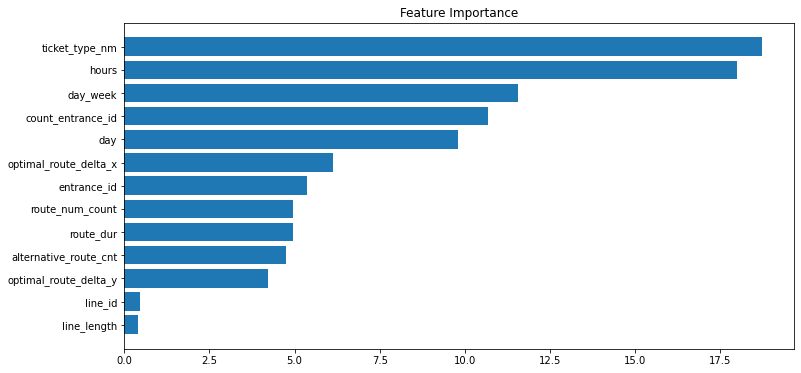

In [35]:
feat_impot(reg)

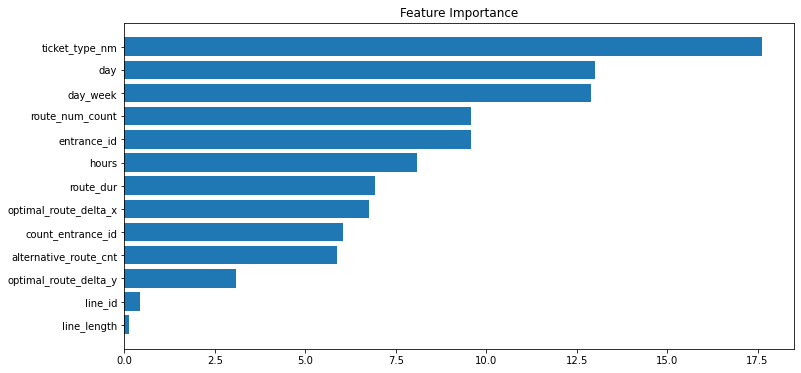

In [36]:
feat_impot(clf)

In [37]:
pred_time = reg.predict(test)

In [38]:
pred_label = clf.predict(test)

# Сохраняем файл

In [39]:
df_sample = pd.read_csv("sample_solution.csv")

In [40]:
df_sample['time_to_under'] = pred_time

In [41]:
df_sample['label'] = pred_label

In [43]:
df_sample.head(5)

,id,time_to_under,label
0,1091022,505.406492,3002
1,1091023,512.642836,3002
2,1091024,515.230827,3002
3,1091025,513.014933,3002
4,1091026,508.833538,3002


In [45]:
# сохраняем файл
df_sample.to_csv("submission_Catboost_v.4_new_features_scaler_PCA_nondownsample.csv", index = False)